<center>
<h1>
    Predicting severities of accidents in the USA
<h1>
<center>

<h3>1. Problem definition<h3>
Let me introduce you to the dataset I'm using in this project. It is the "US accidents updated" and it originates from Kaggle. It is 1.15 GB big and has over 2 million rows of data with over 40 columns. The columns are very interesting, because they consist of every attribute accident could have. Column names such as - what was the weather when it happend, what time did it happened, what month, what road and so on. Based on them, I'm going to try to predict the severity of the accident. </br>


<h4>The project consist of the following:<h4>
1. Data acquisition
2. Data exploration
3. Feature engineering
4. Feature selection
5. Data plotting
6. Preprocessing data
7. Model training and evaluation
8. Results

Side note: this notebook has been run on localhost, Google Colab and Kaggle kernels. The last version I've used it on was Kaggle kernels, because their RAM is 30 GB. Localhost and Google Colab were both 16 GB which in some cases turned out to be not enough. Due to this fact I recommend running this notebook in Kaggle(and it's free) or if your local machine has over 16 GB RAM(I did have problems running on localhost because I changed some PATH variables on Linux and couldn't successfully run it). I tried deleting some things that I don't need in order to lower the RAM usage.

In [282]:
%matplotlib inline

In [283]:
!mkdir data

In [284]:
!pip install scikit-plot
!pip install basemap
!pip install geopandas
!pip install pydotplus

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from dateutil.parser import parse
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt, dates as mdates
from shapely.geometry import Point, Polygon
import geopandas as gpd
from matplotlib import cm
from sklearn import preprocessing
import matplotlib
from sklearn.preprocessing import StandardScaler, label_binarize, PolynomialFeatures, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn import ensemble
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RANSACRegressor, RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc, roc_auc_score, accuracy_score, f1_score
import yellowbrick
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import scikitplot as skplt
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import gc
import os
import glob
import requests, zipfile
import io
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import regularizers
from more_itertools import sliced
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate
import json

In [286]:
for dirname, _, filenames in os.walk('/kaggle/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [287]:
file_url = "https://alicia.data.socrata.com/api/geospatial/jhnu-yfrj?method=export&format=Shapefile"

In [288]:
r = requests.get(file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/data")

In [289]:
def download_dataset():
    json_object = json.dumps({"username":"milenstanev","key":"981835a5f84f013326cd730eb60d485f"})
    with open("kaggle.json", "w") as outfile:
        outfile.write(json_object)
    !pip install -q kaggle 
    !mkdir data
    !mkdir -p ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    ! kaggle datasets download -d sobhanmoosavi/us-accidents
    ! unzip us-accidents.zip -d data

In [290]:
download_dataset()

mkdir: cannot create directory ‘data’: File exists
 99%|████████████████████████████████████████▍| 265M/269M [00:00<00:00, 328MB/s]
100%|█████████████████████████████████████████| 269M/269M [00:00<00:00, 306MB/s]
Archive:  us-accidents.zip
  inflating: data/US_Accidents_Dec21_updated.csv  


In [291]:
df = pd.read_csv("data/US_Accidents_Dec21_updated.csv")
df_copy = df.copy()

In [292]:
len(df.columns)

47

In [293]:
df.shape

(2845342, 47)

In [294]:
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [295]:
len(df)

2845342

In [296]:
df["Severity"].nunique()

4

In [297]:
df["Weather_Timestamp"].value_counts()

2021-12-17 14:53:00    640
2021-12-23 14:53:00    629
2021-01-26 15:53:00    598
2021-12-06 16:53:00    595
2021-12-03 16:53:00    593
                      ... 
2020-11-26 09:15:00      1
2020-10-29 21:26:00      1
2020-09-28 19:36:00      1
2020-11-21 13:27:00      1
2019-08-23 20:50:00      1
Name: Weather_Timestamp, Length: 474214, dtype: int64

In [298]:
len(df)

2845342

First we're going to look at the severity, after all this is the dependant column that we are going to try to predict it.

In [299]:
df["Severity"].describe()

count    2.845342e+06
mean     2.137572e+00
std      4.787216e-01
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      4.000000e+00
Name: Severity, dtype: float64

In [300]:
df["Severity"].unique()

array([3, 2, 4, 1])

We have four values indicating the severity of the accident, ranging from 1 to 4.

In [301]:
len(df["Severity"])

2845342

In [302]:
ones = [x for x in df["Severity"].values if x == 1]

In [303]:
twos = [x for x in df["Severity"].values if x == 2]

In [304]:
df["Severity"].unique()

array([3, 2, 4, 1])

In [305]:
len(twos)

2532991

In [306]:
twos_perc = len(twos) / len(df["Severity"])

In [307]:
threes = [x for x in df["Severity"].values if x == 3]

In [308]:
fours = [x for x in df["Severity"].values if x == 4]

In [309]:
ones_perc = len(ones) / len(df["Severity"])

In [310]:
three_perc = len(threes) / len(df["Severity"])

In [311]:
fours_perc = len(fours) / len(df["Severity"])

In [312]:
twos_perc + three_perc + fours_perc + ones_perc

1.0

In [313]:
data = {1:len(ones), 2: len(twos), 3: len(threes), 4: len(fours) }

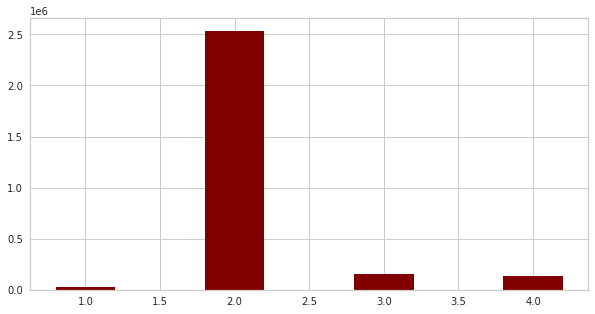

In [314]:
fig = plt.figure(figsize = (10, 5))
plt.bar(data.keys(), data.values(), color ='maroon',
        width = 0.4)
plt.show()

We have highly imbalaced column values.

In [315]:
df.isna().any()

ID                       False
Severity                 False
Start_Time               False
End_Time                 False
Start_Lat                False
Start_Lng                False
End_Lat                  False
End_Lng                  False
Distance(mi)             False
Description              False
Number                    True
Street                    True
Side                     False
City                      True
County                   False
State                    False
Zipcode                   True
Country                  False
Timezone                  True
Airport_Code              True
Weather_Timestamp         True
Temperature(F)            True
Wind_Chill(F)             True
Humidity(%)               True
Pressure(in)              True
Visibility(mi)            True
Wind_Direction            True
Wind_Speed(mph)           True
Precipitation(in)         True
Weather_Condition         True
Amenity                  False
Bump                     False
Crossing

We have to make sure that there are no na/null values in the dataset, otherwise the models would throw an error, I have to either drop it, replace it with median/mean or other value.

In [316]:
columns_na = []
for column in df.columns:
    if(df[column].isna().any()):
        columns_na.append(column)

In [317]:
df["Number"].value_counts()

1.0        10662
2.0         8747
101.0       6706
100.0       6187
198.0       2617
           ...  
42163.0        1
77683.0        1
36887.0        1
45105.0        1
68630.0        1
Name: Number, Length: 46402, dtype: int64

In [318]:
df["Number"].isnull().sum()

1743911

In [319]:
len(df["Number"])

2845342

In [320]:
df["Severity"].isna().any()

False

More than a half of the number column is empty, I will drop it later.

In [321]:
columns_na

['Number',
 'Street',
 'City',
 'Zipcode',
 'Timezone',
 'Airport_Code',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Condition',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight']

Columns that contain na values.

In [322]:
df["Street"].isna().sum()

2

There are just two missing values here, I will replace it with the word Empty later.

In [323]:
column_percent = {}
for column in df.columns:
    if(df[column].isna().any()):
        percent = df[column].isnull().sum() / len(df[column])
        column_percent[percent] = column 

In [324]:
column_percent

{0.6129003121593116: 'Number',
 7.029032010914681e-07: 'Street',
 4.8148869274765566e-05: 'City',
 0.0004635646611198232: 'Zipcode',
 0.0012859614063968408: 'Timezone',
 0.0033560113336112145: 'Airport_Code',
 0.017831248405288363: 'Weather_Timestamp',
 0.02434645817620518: 'Temperature(F)',
 0.16505678403510018: 'Wind_Chill(F)',
 0.025688300387088792: 'Humidity(%)',
 0.020805934752307454: 'Pressure(in)',
 0.024793504612099355: 'Visibility(mi)',
 0.02592834183026153: 'Wind_Direction',
 0.055509671596595415: 'Wind_Speed(mph)',
 0.19310789353265795: 'Precipitation(in)',
 0.02482513525614847: 'Weather_Condition',
 0.0010076117387646194: 'Astronomical_Twilight'}

As we can see the majority of the columns do have missing values, but they are negligebly small. I'm going to drop only the number column since it has more than half of its values missing.

In [325]:
df = df.drop("Number", axis=1)

In [326]:
df["Street"].value_counts()

I-95 N               39853
I-5 N                39402
I-95 S               36425
I-5 S                30229
I-10 E               26164
                     ...  
 Villareal Dr            1
 La Jacaranda            1
 SW 273rd Ln             1
 Silent Brook Dr         1
473-401 Cutoff Rd        1
Name: Street, Length: 159651, dtype: int64

i'm going to replace the missing values with some arbitrary string like "Empty" 

In [327]:
df["Street"].fillna("Empty", inplace=True)

Replacing the missing values with the word Empty

In [328]:
df["Street"].isnull().any()

False

In [329]:
column_percent

{0.6129003121593116: 'Number',
 7.029032010914681e-07: 'Street',
 4.8148869274765566e-05: 'City',
 0.0004635646611198232: 'Zipcode',
 0.0012859614063968408: 'Timezone',
 0.0033560113336112145: 'Airport_Code',
 0.017831248405288363: 'Weather_Timestamp',
 0.02434645817620518: 'Temperature(F)',
 0.16505678403510018: 'Wind_Chill(F)',
 0.025688300387088792: 'Humidity(%)',
 0.020805934752307454: 'Pressure(in)',
 0.024793504612099355: 'Visibility(mi)',
 0.02592834183026153: 'Wind_Direction',
 0.055509671596595415: 'Wind_Speed(mph)',
 0.19310789353265795: 'Precipitation(in)',
 0.02482513525614847: 'Weather_Condition',
 0.0010076117387646194: 'Astronomical_Twilight'}

In [330]:
df["City"].value_counts()

Miami                           106966
Los Angeles                      68956
Orlando                          54691
Dallas                           41979
Houston                          39448
                                 ...  
Ridgedale                            1
Sekiu                                1
Wooldridge                           1
Bullock                              1
American Fork-Pleasant Grove         1
Name: City, Length: 11681, dtype: int64

In [331]:
df["City"].isnull().sum()

137

In [332]:
df["City"].fillna("Empty", inplace=True)

Replacing the missing values with the word Empty

In [333]:
df["City"].isnull().any()

False

In [334]:
df["Zipcode"].value_counts()

91761         6162
33186         5248
92407         4528
92507         4527
91706         4471
              ... 
93306-6165       1
94518-3315       1
29605-5865       1
29048-9475       1
95993-9513       1
Name: Zipcode, Length: 363085, dtype: int64

In [335]:
df["Zipcode"].isnull().sum()

1319

In [336]:
result = df["Zipcode"].interpolate()

In [337]:
result = result.ffill()

In [338]:
result.isnull().any()

False

In [339]:
df["Zipcode"].value_counts()

91761         6162
33186         5248
92407         4528
92507         4527
91706         4471
              ... 
93306-6165       1
94518-3315       1
29605-5865       1
29048-9475       1
95993-9513       1
Name: Zipcode, Length: 363085, dtype: int64

In [340]:
result.value_counts()

91761         6163
33186         5249
92507         4529
92407         4528
91706         4471
              ... 
75212-6112       1
93308-5747       1
92411-1468       1
12154-1931       1
95993-9513       1
Name: Zipcode, Length: 363085, dtype: int64

In [341]:
df["Zipcode"] = df["Zipcode"].interpolate(method="ffill")

As we can see, ffill with interpolate is working just fine, it got all the values spread across all the range.

In [342]:
column_percent

{0.6129003121593116: 'Number',
 7.029032010914681e-07: 'Street',
 4.8148869274765566e-05: 'City',
 0.0004635646611198232: 'Zipcode',
 0.0012859614063968408: 'Timezone',
 0.0033560113336112145: 'Airport_Code',
 0.017831248405288363: 'Weather_Timestamp',
 0.02434645817620518: 'Temperature(F)',
 0.16505678403510018: 'Wind_Chill(F)',
 0.025688300387088792: 'Humidity(%)',
 0.020805934752307454: 'Pressure(in)',
 0.024793504612099355: 'Visibility(mi)',
 0.02592834183026153: 'Wind_Direction',
 0.055509671596595415: 'Wind_Speed(mph)',
 0.19310789353265795: 'Precipitation(in)',
 0.02482513525614847: 'Weather_Condition',
 0.0010076117387646194: 'Astronomical_Twilight'}

In [343]:
columns_percent_arr = list(column_percent.values())

In [344]:
columns_with_over_fifteen = []
columns_with_less_fifteen = []

In [345]:
for column in columns_percent_arr[4:]:
    percent = df[column].isnull().sum() / len(df[column])
    if percent > 0.15:
        columns_with_over_fifteen.append(column)
    else:
        columns_with_less_fifteen.append(column)

Calculating the percentage of missing values from the columns.

In [346]:
columns_with_over_fifteen

['Wind_Chill(F)', 'Precipitation(in)']

In [347]:
df["Wind_Chill(F)"].fillna(df["Wind_Chill(F)"].mean(), inplace=True)

I'm going to replace all the missing values with the mean of the column. The missing values are not that much and I will take advantage of that.

In [348]:
df["Wind_Chill(F)"].isnull().any()

False

In [349]:
df["Precipitation(in)"].fillna(df["Precipitation(in)"].mean(), inplace=True)

Same here as the cell above.

In [350]:
df["Precipitation(in)"].isnull().any()

False

In [351]:
for column in columns_with_less_fifteen:
    df[column].interpolate(method="ffill", inplace=True)

I'm using the interpolate method to fill the missing values. As I've mentioned before, they are close to zero and I think it will not matter for the prediction power of the models, but they cannot work with na/null values, so they have to replaced on way or another.

In [352]:
for column in columns_with_less_fifteen:
    if df[column].isnull().any():
        print(column)

In [353]:
df["Sunrise_Sunset"].isna().sum()

2867

In [354]:
len(df.columns)

46

In [355]:
columns_with_less_fifteen

['Timezone',
 'Airport_Code',
 'Weather_Timestamp',
 'Temperature(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Weather_Condition',
 'Astronomical_Twilight']

In [356]:
df["Sunrise_Sunset"].isnull().sum()

2867

In [357]:
df.isnull().any()

ID                       False
Severity                 False
Start_Time               False
End_Time                 False
Start_Lat                False
Start_Lng                False
End_Lat                  False
End_Lng                  False
Distance(mi)             False
Description              False
Street                   False
Side                     False
City                     False
County                   False
State                    False
Zipcode                  False
Country                  False
Timezone                 False
Airport_Code             False
Weather_Timestamp        False
Temperature(F)           False
Wind_Chill(F)            False
Humidity(%)              False
Pressure(in)             False
Visibility(mi)           False
Wind_Direction           False
Wind_Speed(mph)          False
Precipitation(in)        False
Weather_Condition        False
Amenity                  False
Bump                     False
Crossing                 False
Give_Way

In [358]:
for column in df.columns:
    if df[column].isnull().any():
        print(column)

Sunrise_Sunset
Civil_Twilight
Nautical_Twilight


In [359]:
df["Sunrise_Sunset"].unique()

array(['Night', 'Day', nan], dtype=object)

In [360]:
df["Sunrise_Sunset"].value_counts()

Day      1811935
Night    1030540
Name: Sunrise_Sunset, dtype: int64

In [361]:
sunrise_day_perc = df["Sunrise_Sunset"].value_counts()[0] / len(df["Sunrise_Sunset"])

In [362]:
sunrise_night_perc = df["Sunrise_Sunset"].value_counts()[1] / len(df["Sunrise_Sunset"])

In [363]:
sunrise_day_perc

0.6368074558348347

In [364]:
sunrise_night_perc

0.36218493242640076

In [365]:
df["Sunrise_Sunset"].isnull().sum()

2867

In [366]:
df["Sunrise_Sunset"].interpolate(method="ffill",inplace=True)

Again replacing the na values with the same distribution as the other two classes.

In [367]:
sunrise_day_perc = df["Sunrise_Sunset"].value_counts()[0] / len(df["Sunrise_Sunset"])

In [368]:
sunrise_night_perc = df["Sunrise_Sunset"].value_counts()[1] / len(df["Sunrise_Sunset"])

In [369]:
sunrise_day_perc

0.6374702935534639

In [370]:
sunrise_night_perc

0.36252970644653615

Percentages stay almost the same.

In [371]:
df["Civil_Twilight"].unique()

array(['Night', 'Day', nan], dtype=object)

In [372]:
df["Civil_Twilight"].value_counts()

Day      1929103
Night     913372
Name: Civil_Twilight, dtype: int64

In [373]:
df["Civil_Twilight"].interpolate(method="ffill",inplace=True)

Implementing the same method of filling the missing values.

In [374]:
df["Nautical_Twilight"].value_counts()

Day      2063472
Night     779003
Name: Nautical_Twilight, dtype: int64

In [375]:
df["Nautical_Twilight"].unique()

array(['Night', 'Day', nan], dtype=object)

In [376]:
df["Nautical_Twilight"].interpolate(method="ffill", inplace=True)

In [377]:
df.isnull().sum()

ID                       0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
Description              0
Street                   0
Side                     0
City                     0
County                   0
State                    0
Zipcode                  0
Country                  0
Timezone                 0
Airport_Code             0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
S

I've used ffill method because it's kind of a method. I might have better results with a different fill, but the missing values from that columns that I've used the method on are just so small that it might not matter.

<center>
    <h2>
        Exploratory Data Analysis
    <h2>
<center>

First we are going to start with the dependant column or the target column

In [378]:
df["Severity"].unique()
len(df["Severity"])

2845342

In [379]:
ones = [x for x in df["Severity"] if x == 1]
twos = [x for x in df["Severity"] if x == 2]
threes = [x for x in df["Severity"] if x == 3]
fours = [x for x in df["Severity"] if x == 4]

In [380]:
data = {1:len(ones), 2: len(twos), 3: len(threes), 4: len(fours)}

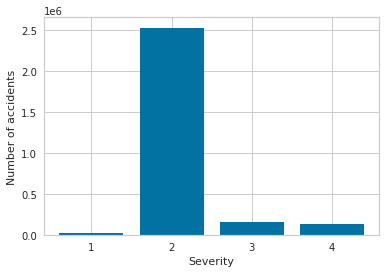

In [381]:
plt.bar(df["Severity"].value_counts().keys(), df["Severity"].value_counts())
plt.xticks(df["Severity"].unique())
plt.xlabel("Severity")
plt.ylabel("Number of accidents")
plt.show()

As we can see, the target column is highly imbalanced, with high probability of a car accident to be second severity.

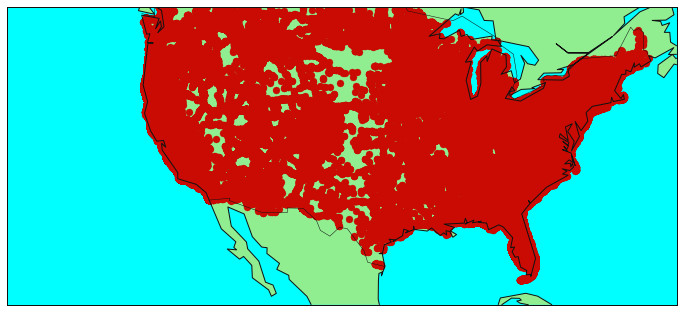

In [382]:
plt.figure(figsize = (12, 10))
m = Basemap(projection = "merc", llcrnrlon=-140,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49)
x = df["Start_Lat"].values 
y = df["Start_Lng"].values
x, y = m(y, x)
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = "lightgreen", lake_color = "aqua")
m.drawmapboundary(fill_color = "aqua")
plt.scatter(x,y,c="r")
plt.show()

In [383]:
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [384]:
df["Description"].max()

"x DRESSER RANCH PL. LL SLOSO - DIRECTIONS PER FIRE AND MEDICS: GATE LEFT OPEN BY FIRE AND MEDICS // STAY TO THE LEFT ONCE YOU GO IN // RIGHT AT THE FORK THERE'S AN OLD TK // THEN AN OLD BRIDGE - DON'T CROSS THE BRIDGE BUT GO AROUND TO THE VINEYARD // 1/4 MILE FROM TK AND BRIDGE"

If I have enough time, I will make a model that works with the data column. Maybe there are some underlying logic.

In [385]:
lengths = [len(x) for x in df["Description"]]

In [386]:
max(lengths)

577

In [387]:
lengths.index(max(lengths))

1979338

In [388]:
df["Description"][1979338]

"HOURGLASS COMMUNITY PARK PLOT. RP CALLING 911 BECAUSE HE IS BEING FOLLOWED BY UNK VEH / DOESN'T KNOW WHY HE IS BEING FOLLOWED / IT STARTED FOLLOWING HIM SINCE SB 15 JNO TIERRASANTA WHEN THE VEH TC'D THE BACK OF HIS VEH / RP GOT SCARED AND DROVE AWAY TRYING TO LOOSE THAT VEH / VEH FOLLOWED HIM ONTO SD CITY STREETS WHERE RP APPARENTLY LOST HIM / I SUGGESTED TO RP THAT PERHAPS HE IS BEING FOLLOWED BECAUSE RP DID NOT PULL OVER AFTER TC / RP CONTEMPLATED ON THAT AND CONCLUDED THAT I MAY BE RIGHT / RP PULLED INTO HOURGLASS COMMUNITY PARK 10440 BLACK MOUNTAIN RD TO 1023 FOR CHP"

So, we have a column that has description of the accident. If I have enough time, I might do nlp with tensorflow, but it will be some simple model.

In [389]:
df.columns[30:]

Index(['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

<center>
<h2>
    Plotting the data
<h2>
<center>

In [390]:
df["Severity"].value_counts().keys()
df["Severity"].value_counts()

2    2532991
3     155105
4     131193
1      26053
Name: Severity, dtype: int64

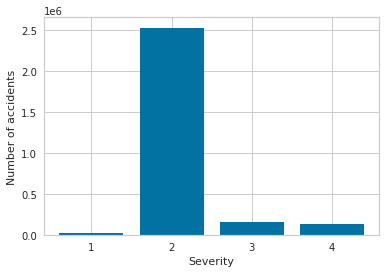

In [391]:
plt.bar(df["Severity"].value_counts().keys(), df["Severity"].value_counts())
plt.xticks(df["Severity"].unique())
plt.xlabel("Severity")
plt.ylabel("Number of accidents")
plt.show()

As we can see most of the accidents are second class and highly imbalanced

First i'm going to see if most of the accidents occur in some notable months..not notable but exceedingly high 
amount of accidents could occur in some months

In [392]:
converted_date = pd.to_datetime(df["Start_Time"].value_counts().keys())
converted_date.size
df["Start_Time"].value_counts()

2021-01-26 16:16:13    214
2021-01-26 16:17:33    150
2021-02-16 06:42:43    130
2021-05-03 06:29:42     92
2021-04-26 08:58:47     87
                      ... 
2021-10-08 03:58:30      1
2021-12-16 23:53:00      1
2021-07-27 18:46:31      1
2021-10-26 17:37:30      1
2019-08-23 18:52:06      1
Name: Start_Time, Length: 1959333, dtype: int64

In [393]:
df["Start_Time"].value_counts().keys()

Index(['2021-01-26 16:16:13', '2021-01-26 16:17:33', '2021-02-16 06:42:43',
       '2021-05-03 06:29:42', '2021-04-26 08:58:47', '2021-02-16 06:43:35',
       '2021-11-21 18:37:51', '2020-12-16 13:53:25', '2021-04-14 13:51:30',
       '2021-05-03 06:30:28',
       ...
       '2021-07-31 12:38:49', '2021-12-12 09:48:41', '2021-03-27 06:50:30',
       '2021-12-12 22:17:07', '2021-10-25 05:12:12', '2021-10-08 03:58:30',
       '2021-12-16 23:53:00', '2021-07-27 18:46:31', '2021-10-26 17:37:30',
       '2019-08-23 18:52:06'],
      dtype='object', length=1959333)

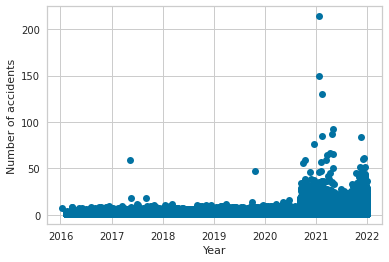

In [394]:
plt.plot_date(converted_date, df["Start_Time"].value_counts())
plt.xlabel("Year")
plt.ylabel("Number of accidents")
plt.show()

So, there are a consistent amount of accidents throughout the years, there is a gradual increase but not that substantial from 2016 to the mid 2020. There are couple of outliers. But most importantly from around 3/4 of 2020 something happend. A huge spike in the accidents could be seen and i contribute that to covid pandemic and restrictions being raised.

In [395]:
days = df["Start_Time"].value_counts().keys().map(lambda x: x.split()[0])
len(days)

1959333

In [396]:
months = df["Start_Time"].value_counts().keys()[0].split("-")[1]

In [397]:
df["Start_Time"].value_counts()

2021-01-26 16:16:13    214
2021-01-26 16:17:33    150
2021-02-16 06:42:43    130
2021-05-03 06:29:42     92
2021-04-26 08:58:47     87
                      ... 
2021-10-08 03:58:30      1
2021-12-16 23:53:00      1
2021-07-27 18:46:31      1
2021-10-26 17:37:30      1
2019-08-23 18:52:06      1
Name: Start_Time, Length: 1959333, dtype: int64

In [398]:
int(df["Start_Time"][0].split()[0].split("-")[1])

2

In [399]:
date_dictionary = defaultdict(int)
for x in df["Start_Time"]:
    date_dictionary[int(x.split()[0].split("-")[1])] += 1

In [400]:
something = list(date_dictionary.values())

In [401]:
sum(something)

2845342

In [402]:
len(df["Start_Time"])

2845342

In [403]:
date_dictionary.keys()

dict_keys([2, 3, 4, 5, 6, 11, 12, 1, 10, 9, 8, 7])

In [404]:
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

In [405]:
something = list(date_dictionary.keys())

In [406]:
leading_zeros = [int(x) for x in something]
leading_zeros

[2, 3, 4, 5, 6, 11, 12, 1, 10, 9, 8, 7]

In [407]:
leading_zeros = sorted(leading_zeros)

In [408]:
months_string = [print(x) for x in leading_zeros]

1
2
3
4
5
6
7
8
9
10
11
12


In [409]:
print(months)

{1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}


In [410]:
months_string = []
for x in leading_zeros:
    months_string.append(months[x])

In [411]:
date_dictionary.values()

dict_values([194995, 158224, 171880, 181944, 226561, 360696, 473943, 198365, 299131, 241822, 178670, 159111])

In [412]:
months_string

['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

In [413]:
something = sorted(leading_zeros)

In [414]:
something

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [415]:
values = [x for x in date_dictionary.values()]
values

[194995,
 158224,
 171880,
 181944,
 226561,
 360696,
 473943,
 198365,
 299131,
 241822,
 178670,
 159111]

In [416]:
values = []
for x in date_dictionary.keys():
    values.append(date_dictionary[x])
values

[194995,
 158224,
 171880,
 181944,
 226561,
 360696,
 473943,
 198365,
 299131,
 241822,
 178670,
 159111]

In [417]:
date_dictionary[1]

198365

In [418]:
date_dictionary

defaultdict(int,
            {2: 194995,
             3: 158224,
             4: 171880,
             5: 181944,
             6: 226561,
             11: 360696,
             12: 473943,
             1: 198365,
             10: 299131,
             9: 241822,
             8: 178670,
             7: 159111})

In [419]:
months

{1: 'Jan',
 2: 'Feb',
 3: 'Mar',
 4: 'Apr',
 5: 'May',
 6: 'Jun',
 7: 'Jul',
 8: 'Aug',
 9: 'Sep',
 10: 'Oct',
 11: 'Nov',
 12: 'Dec'}

In [420]:
result = {}
for x in range(1,13):
    result[months[x]] = date_dictionary[x]

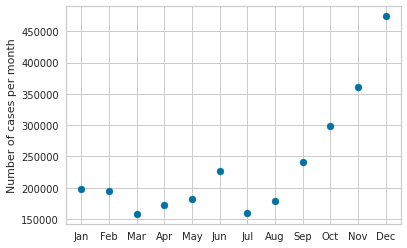

In [421]:
plt.scatter(result.keys(), result.values())
plt.ylabel("Number of cases per month")
plt.show()

As we could see there are some spikes in June and I could attribute that to the summer or spring breaks in the US. But there is almost logarithmic trend from September to October. I don't why that's the way it is, but major holidays throughout the country are happening such as Halloween, Christmas, New years eve. The peak is December when everybody is on holiday or on Paid leave from work.

In [422]:
df["Start_Time"]

0          2016-02-08 00:37:08
1          2016-02-08 05:56:20
2          2016-02-08 06:15:39
3          2016-02-08 06:51:45
4          2016-02-08 07:53:43
                  ...         
2845337    2019-08-23 18:03:25
2845338    2019-08-23 19:11:30
2845339    2019-08-23 19:00:21
2845340    2019-08-23 19:00:21
2845341    2019-08-23 18:52:06
Name: Start_Time, Length: 2845342, dtype: object

In [423]:
hour_dictionary = defaultdict(int)

In [424]:
for x in df["Start_Time"]:
    hour_dictionary[int(x.split()[1].split(":")[0])] += 1

In [425]:
zero_to_23 = [x for x in range(0,24)]

In [426]:
result_dict = {}
for x in range(0,24):
    result_dict[zero_to_23[x]] = hour_dictionary[x]

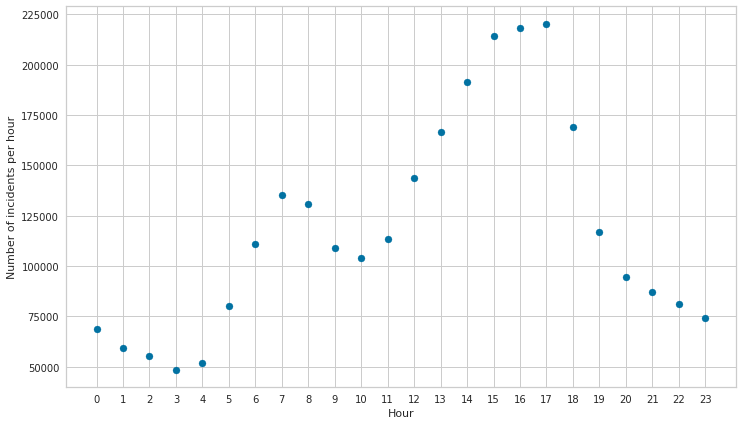

In [427]:
plt.figure(figsize=(12,7))
plt.scatter(result_dict.keys(), result_dict.values())
plt.xticks(np.arange(0,24,1))
plt.xlabel("Hour")
plt.ylabel("Number of incidents per hour")
plt.show()

As we can see, there are clearly two peaks(bimodal distribution) here. The one is around 7 or 8 o'clock and it could maybe attributed to people going to work and streets are flooded with the working class people. The second peak is much larger and it peaks around 16 17 o'clock and it helps my thesis of the working class people coming back from work. It's also that part of the day where it's not sunny and street lamps are not lit up, which makes it also harder to see things clearly.

In [428]:
df.rename(columns = {"Distance(mi)": "Distance(km)"}, inplace = True)

In [429]:
df["Distance(km)"][:5]

0    3.230
1    0.747
2    0.055
3    0.123
4    0.500
Name: Distance(km), dtype: float64

In [430]:
df["Distance(km)"] = df["Distance(km)"] * 1.6

Making the column from miles to kilometers.

In [431]:
df["Distance(km)"].max()

248.29760000000002

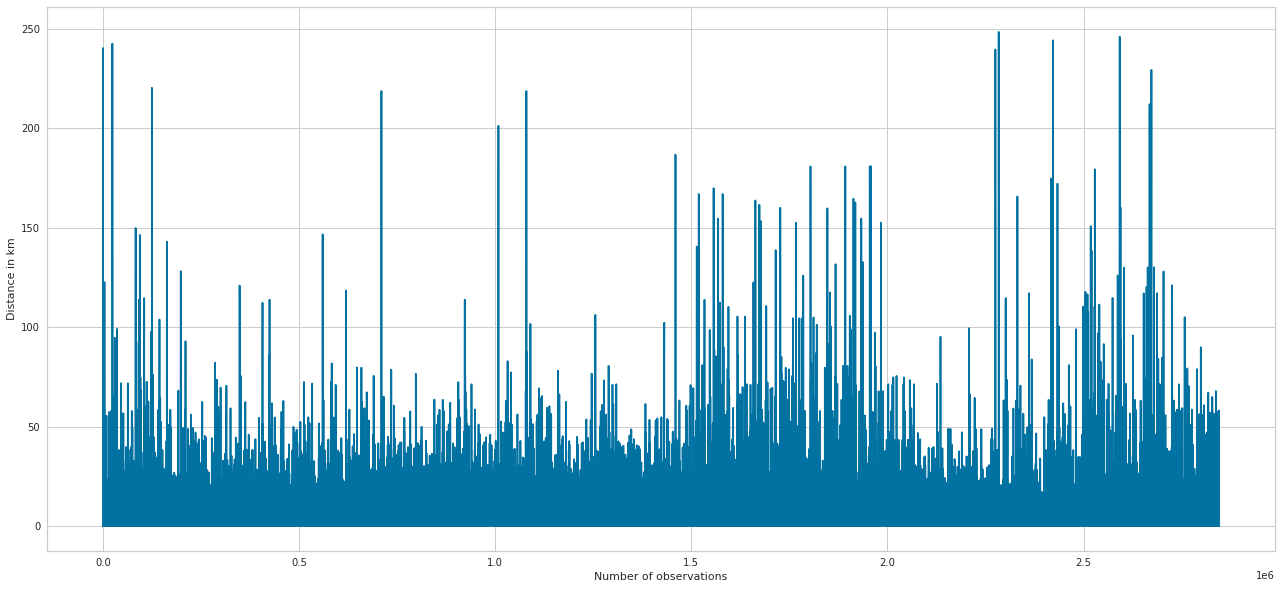

In [432]:
plt.figure(figsize=(22,10))
plt.plot(df["Distance(km)"])
plt.xlabel("Number of observations")
plt.ylabel("Distance in km")
plt.show()

Well, there are peaks from time to time but most of the accidents are below 20 mark.

In [433]:
street_df = pd.DataFrame(df["Street"].value_counts()).reset_index().rename(columns={"index":"Street No", "Street": "Cases"})

In [434]:
top_ten_street = street_df[:10]

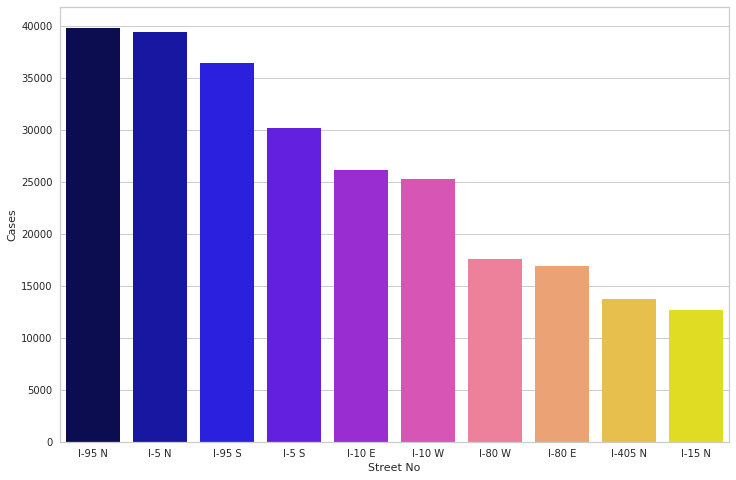

In [435]:
plt.figure(figsize=(12,8))
sns.barplot(x=top_ten_street["Street No"], y=top_ten_street["Cases"], palette="gnuplot2")
plt.show()

These are the top 10 deadliest roads in america according to the dataset. The top 3 consist of I-95 North and South, and with a quick google search, they are the most deadly. Closely behind there are I-5 North and South, which is in California. It is home to about 40 million people, so they are somewhat prone to a lot of incidents. In the top 5 comes I-10 East and West, it's like our Trakiya, but not exactly. It is crossing almost all of the US from West to East and it's a loong road. And if it's a long road, there are more likely incidents happening there.

In [436]:
df["Side"].unique()

array(['R', 'L', 'N'], dtype=object)

In [437]:
side_df = pd.DataFrame(df["Side"].value_counts()).reset_index().rename(columns={"index":"Side", "Side":"Number of incidents"})

In [438]:
side_df

,Side,Number of incidents
0,R,2353309
1,L,492032
2,N,1


i dont really know what N is and why it's here but alright??????
dont really know what R and L is, maybe it's the driver position 

In [439]:
percentage = []
for x in df["Side"].value_counts():
    percentage.append(x / len(df["Side"]))

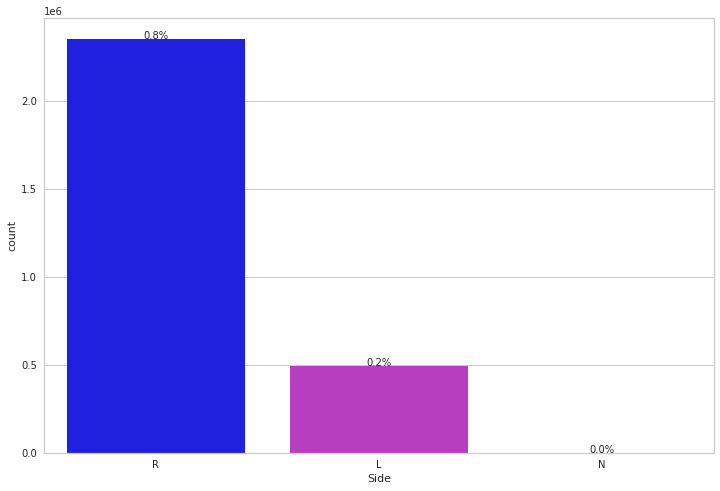

In [440]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df["Side"], palette="gnuplot2")
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.show()

This is the distribution of left and right column which shows the relative side of the road.

In [441]:
df_county = pd.DataFrame(df["County"].value_counts()).reset_index().rename(columns={"index":"County", "County":"Number of incidents"})

In [442]:
df_county

,County,Number of incidents
0,Los Angeles,234122
1,Miami-Dade,143939
2,Orange,114917
3,San Bernardino,55018
4,Dallas,50050
...,...,...
1702,Kearney,1
1703,Matagorda,1
1704,Oglala Lakota,1
1705,St John The Baptist,1


In [443]:
top_15_counties = df_county[:15]

In [444]:
df_county[:15]

,County,Number of incidents
0,Los Angeles,234122
1,Miami-Dade,143939
2,Orange,114917
3,San Bernardino,55018
4,Dallas,50050
5,San Diego,48366
6,Sacramento,46708
7,Harris,42559
8,Riverside,42176
9,Montgomery,41476


In [445]:
percentage = []
for x in top_15_counties["Number of incidents"]:
    percentage.append(x / len(df["County"]))

In [446]:
percentage

[0.08228255162296835,
 0.050587591930952414,
 0.04038776357991412,
 0.019336164158825195,
 0.01759015260731399,
 0.016998308111994972,
 0.016415601358290146,
 0.014957428667625896,
 0.01482282270461688,
 0.014576806584234865,
 0.013705558066481991,
 0.012367933274804926,
 0.011787335230703374,
 0.011127660576479032,
 0.009635045628961298]

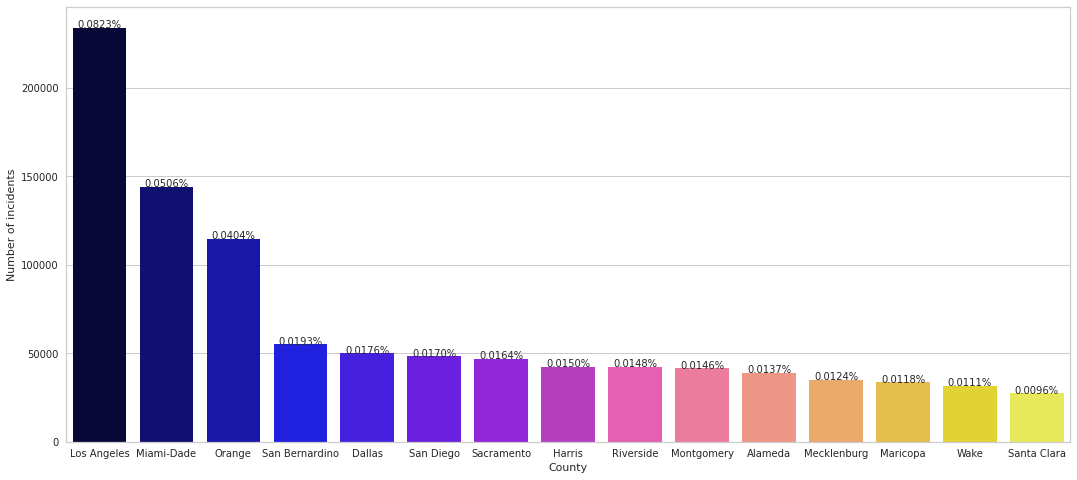

In [447]:
plt.figure(figsize=(18,8))
ax = sns.barplot(y=top_15_counties["Number of incidents"], x=top_15_counties["County"], palette="gnuplot2")
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.4f}%'.format(percentage[i]), (x, y), ha='center')
plt.show()

So, there we have it..top 10 countys that incidents happen in. Nearly 10 percent of all incidents happen in Los Angeles. There is a gradual increase until the top 3. Something is governing this processes, maybe top 3 are more populous, more tourist, more people coming to enjoy night life or something like this.!!!!!!!!!!|

In [448]:
os.chdir("/data")
for file in glob.glob("*.shp"):
    usa = gpd.read_file(file)

<AxesSubplot:>

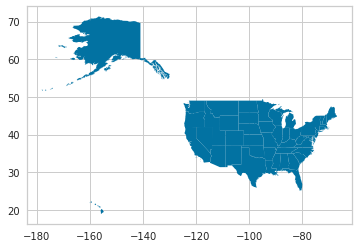

In [449]:
usa.plot()

In [450]:
def state_plotter(states, us_map=True):
    fig, ax = plt.subplots(figsize=(30,30))
    if us_map:
        if 'HI' in states:
            usa[0:50].plot(ax=ax, alpha = 0.3)
        elif 'AK' in states:
            usa[l:51].plot(ax=ax, alpha = 0.3)
        elif 'AK' and 'HI' in states:
            usa[0:51].plot(ax=ax, alpha = 0.3)
        else:
            usa[0:50].plot(ax=ax, alpha = 0.3)
        for n in states:
            usa[usa.state_abbr == f'{n}'].plot(ax=ax, edgecolor='y', linewidth =2)
    elif us_map == False:
        for n in states:
            usa[usa.state_abbr == f'{n}'].plot(ax=ax, edgecolor='y', linewidth =2)

In [451]:
usa["state_name"]

0                   Hawaii
1               Washington
2                  Montana
3                    Maine
4             North Dakota
5             South Dakota
6                  Wyoming
7                Wisconsin
8                  Vermont
9                    Idaho
10               Minnesota
11            Pennsylvania
12                  Oregon
13           New Hampshire
14             Connecticut
15            Rhode Island
16                    Iowa
17           Massachusetts
18                    Utah
19                Nebraska
20                New York
21              New Jersey
22                 Indiana
23                  Nevada
24              California
25                    Ohio
26                Maryland
27                Illinois
28    District of Columbia
29                Delaware
30                Colorado
31           West Virginia
32                Kentucky
33                  Kansas
34                Virginia
35                Missouri
36                 Arizona
3

In [452]:
state_dict = defaultdict()

In [453]:
for x in zip(usa["state_abbr"], usa["state_name"]):
    state_dict[x[0]] = x[1]

In [454]:
df_state = pd.DataFrame(df["State"].value_counts()).reset_index().rename(columns={"index":"State","State":"Number of accidents"})

In [455]:
df_state["State"] = [state_dict[x] for x in df_state["State"].values]

In [456]:
top_10_states = df_state[:10]
top_10_states

,State,Number of accidents
0,California,795868
1,Florida,401388
2,Texas,149037
3,Oregon,126341
4,Virginia,113535
5,New York,108049
6,Pennsylvania,99975
7,Minnesota,97185
8,North Carolina,91362
9,South Carolina,89216


Top 10 states by accidents.

In [457]:
percentage = []
for x in top_10_states["Number of accidents"]:
    percentage.append(x / len(df["State"]))

In [458]:
top_10_states["Number of accidents"]

0    795868
1    401388
2    149037
3    126341
4    113535
5    108049
6     99975
7     97185
8     91362
9     89216
Name: Number of accidents, dtype: int64

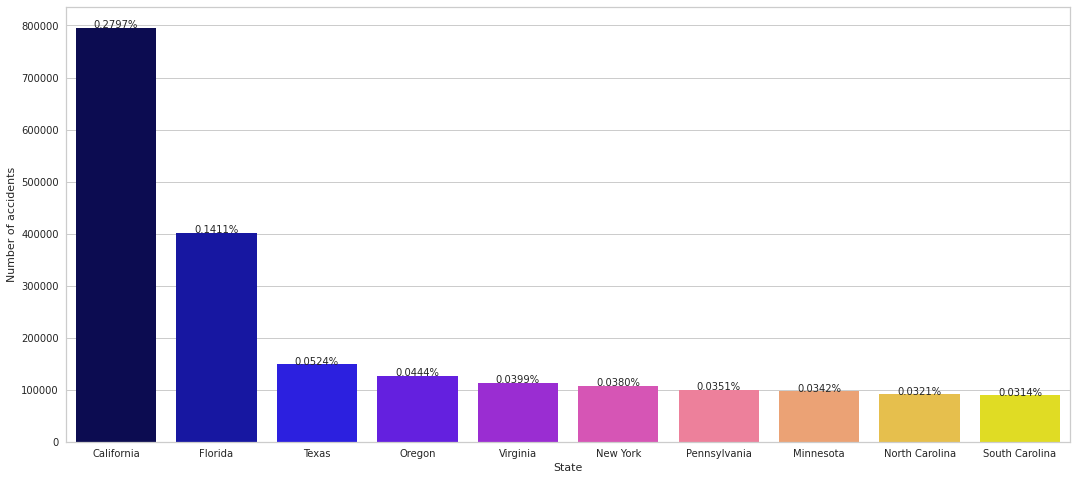

In [459]:
plt.figure(figsize=(18,8))
ax = sns.barplot(y=top_10_states["Number of accidents"], x=top_10_states["State"], palette="gnuplot2")
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.4f}%'.format(percentage[i]), (x, y), ha='center')
plt.show()

* 27 percent of the accidents occur in the state of California.
* Almost double below that result is the second: Florida.
* All others are evenly distributed amongst the other states.

In [460]:
df["Zipcode"]

0          43017
1          45424
2          45203
3          44311
4          45217
           ...  
2845337    92501
2845338    92108
2845339    92866
2845340    90230
2845341    92346
Name: Zipcode, Length: 2845342, dtype: object

I think i will drop this column, it does not bring anything meaningful to the table, it's just the state zipcode

In [461]:
df["Country"].unique()

array(['US'], dtype=object)

I'm going to drop this col as well, because the only country in the column is the us.

In [462]:
df_timezone = pd.DataFrame(df["Timezone"].value_counts()).reset_index().rename(columns={"index":"Timezone","Timezone":"Number of incidents"})

In [463]:
df_timezone

,Timezone,Number of incidents
0,US/Eastern,1223274
1,US/Pacific,968721
2,US/Central,488460
3,US/Mountain,164887


In [464]:
percentage = []
for x in df_timezone["Number of incidents"]:
    percentage.append(x / len(df["Timezone"]))

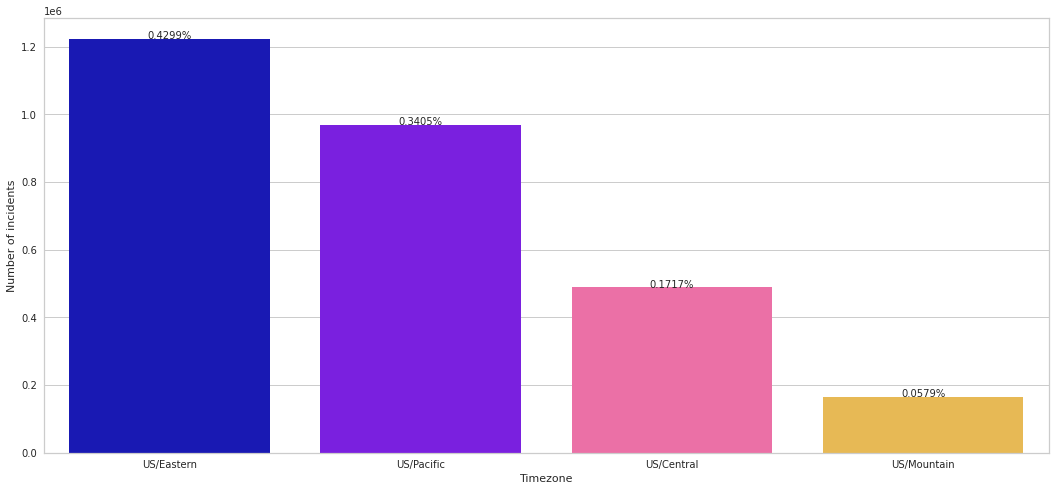

In [465]:
plt.figure(figsize=(18,8))
ax = sns.barplot(y=df_timezone["Number of incidents"], x=df_timezone["Timezone"], palette="gnuplot2")
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.4f}%'.format(percentage[i]), (x, y), ha='center')
plt.show()

There are couple of things that are interesting here
* More or less half of the accidents happen in the eastern part of the country which kind of makes sense because it is more densely populated than the others.
* Five percent of the accidents occur in the mountain region of the country which is less populated than the others

In [466]:
df["Airport_Code"].nunique()

2004

i think i will drop this column also, it does not bring anything new in my opinion.

In [467]:
df["Weather_Timestamp"][:3]

0    2016-02-08 00:53:00
1    2016-02-08 05:58:00
2    2016-02-08 05:53:00
Name: Weather_Timestamp, dtype: object

I'm going to drop this as well, I have it already plotted 

In [468]:
df["Temperature(F)"]

0          42.1
1          36.9
2          36.0
3          39.0
4          37.0
           ... 
2845337    86.0
2845338    70.0
2845339    73.0
2845340    71.0
2845341    79.0
Name: Temperature(F), Length: 2845342, dtype: float64

In [469]:
df.rename(columns = {"Temperature(F)": "Temperature(C)"}, inplace = True)

In [470]:
df["Temperature(C)"] = [(5/9 * (x - 32)) for x in df["Temperature(C)"]]

Converting the temperature from Fahrenheit to Celcius.

In [471]:
df_temperature = pd.DataFrame(df["Temperature(C)"].value_counts()).reset_index().rename(columns={"index":"Temperature(C)", "Temperature(C)": "Number of accidents"})

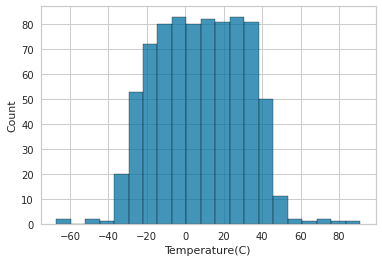

In [472]:
sns.histplot(df_temperature, x="Temperature(C)")
plt.show()

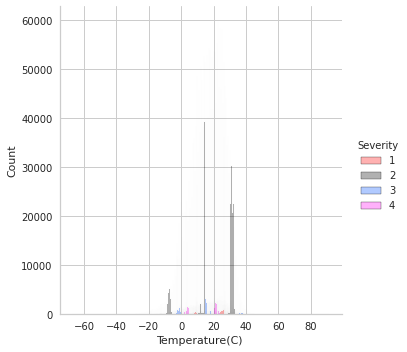

In [473]:
plot = sns.displot(df, x="Temperature(C)", hue="Severity", palette=["#FF0000", "#000000", "#0051FF", "#FF00F3"], alpha=0.3, multiple='dodge')
plt.show()

The twos are the overwhelming majority of the classes, but still some things could be seen
* Most of the incidents happen around 20 degrees 
* The most severe accidents have binomial distribution which is interesting

In [475]:
df.rename(columns={"Wind_Chill(F)":"Wind_Chill(C)"}, inplace=True)

In [476]:
df["Wind_Chill(C)"] = [(5/9 * (x - 32)) for x in df["Wind_Chill(C)"]]

Again, transforming Fahrenheit to Celcius.

In [478]:
df_wind = pd.DataFrame(df["Wind_Chill(C)"].value_counts()).reset_index().rename(columns={"index":"Wind_Chill(C)", "Wind_Chill(C)":"Number of accidents"})

In [479]:
df_wind

,Wind_Chill(C),Number of accidents
0,15.365684,469643
1,22.777778,56492
2,25.000000,53359
3,23.888889,52898
4,22.222222,52196
...,...,...
893,-42.944444,1
894,-44.777778,1
895,62.222222,1
896,-38.500000,1


In [480]:
percentage = []
for x in df_wind["Number of accidents"]:
    percentage.append(x / len(df["Wind_Chill(C)"]))

In [481]:
df_wind = df_wind[:10]

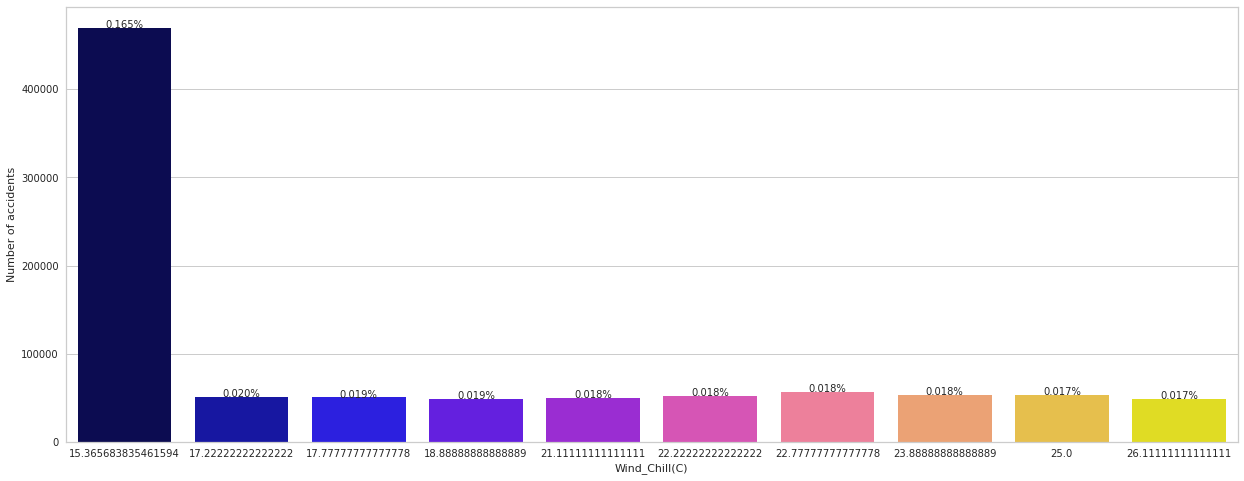

In [482]:
plt.figure(figsize=(21,8))
ax = sns.barplot(y=df_wind["Number of accidents"], x=df_wind["Wind_Chill(C)"], palette="gnuplot2")
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.3f}%'.format(percentage[i]), (x, y), ha='center')
plt.show()

There are a lot of values in the exact 15 degrees, then the rest are evenly distributed as far as the top 10 records.

In [483]:
severity_without_2 = [x for x in df["Severity"] if x != 2]

In [484]:
count = 0
for x in severity_without_2:
    count += 1
count

312351

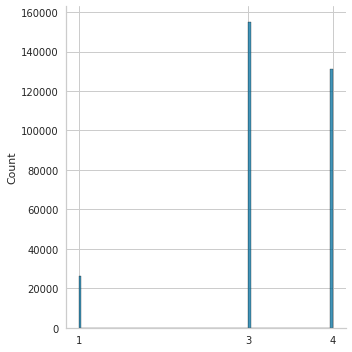

In [485]:
sns.displot(severity_without_2)
plt.xticks([1,3,4])
plt.show()

What would the severity columns look like if there was no second class.

In [486]:
df_humidity = pd.DataFrame(df["Humidity(%)"].value_counts()).reset_index().rename(columns={"index":"Humidity(%)","Humidity(%)":"Number of accidents"})

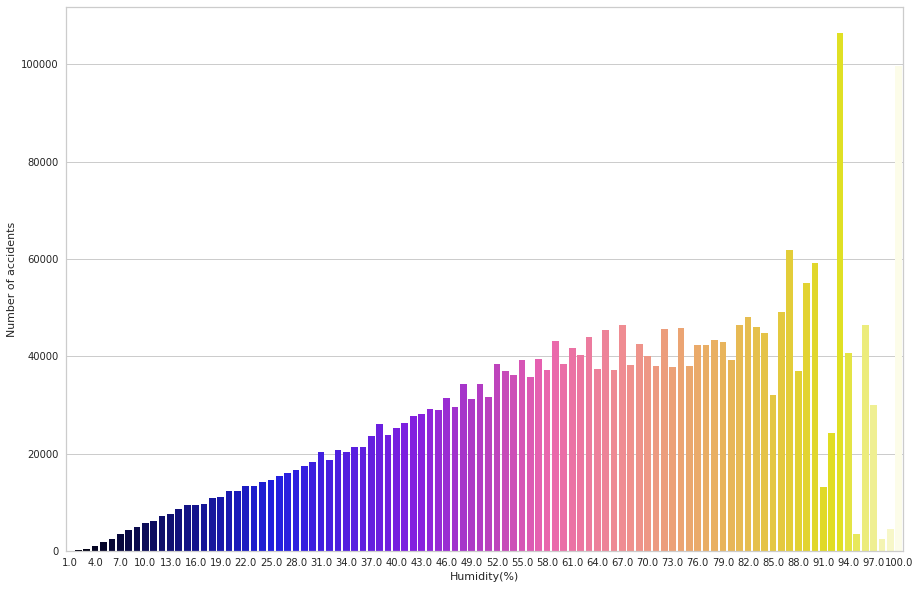

In [487]:
plt.figure(figsize=(15,10))
ax = sns.barplot(y=df_humidity["Number of accidents"], x=df_humidity["Humidity(%)"], palette="gnuplot2")
plt.xticks(np.arange(0,100,3))
plt.show()

As we can see, we have almost linear increase in the humidity with a few exceptions(for severity of two). The other severities for example three and four follow a much more stable behaviour. But still, there are many accidents just around 92 humidity (more than 80000 cases). Most of the cases are around 90 and 95 humidity

In [488]:
df.rename(columns={"Pressure(in)":"Pressure(cm)"}, inplace=True)

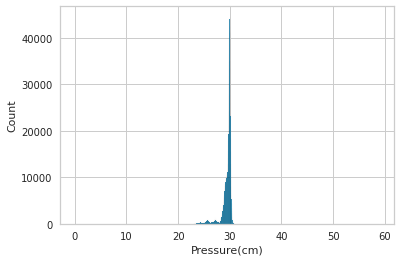

In [489]:
sns.histplot(df, x="Pressure(cm)")
plt.show()

Maybe some other plot will help

In [490]:
df_pressure = pd.DataFrame(df["Pressure(cm)"].value_counts()).reset_index().rename(columns={"index":"Pressure(cm)", "Pressure(cm)":"Number of accidents"})

In [491]:
df_pressure

,Pressure(cm),Number of accidents
0,29.96,44521
1,29.94,44020
2,29.99,43835
3,30.01,42565
4,30.03,42335
...,...,...
1063,21.83,1
1064,0.02,1
1065,58.13,1
1066,0.00,1


In [492]:
percentage = []
for x in df_pressure["Number of accidents"]:
    percentage.append(x / len(df_pressure["Pressure(cm)"]))

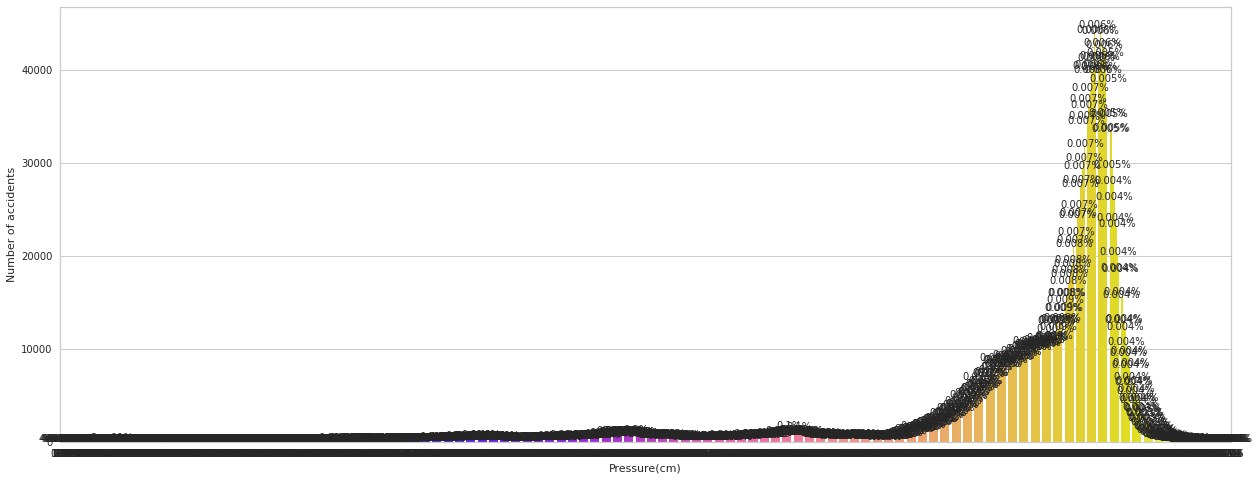

In [493]:
plt.figure(figsize=(21,8))
ax = sns.barplot(y=df_pressure["Number of accidents"], x=df_pressure["Pressure(cm)"], palette="gnuplot2")
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.1}%'.format(percentage[i]), (x, y), ha='center')
plt.show()

I couldn't make this plot work the way I wanted, but in essence, the more the pressure is, the more the accidents are, but this trend stops right before the end.

In [494]:
def compute_histogram_bins(data, desired_bin_size):
    min_val = np.min(data)
    max_val = np.max(data)
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int((max_boundary - min_boundary) / desired_bin_size) + 1
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    return bins

In [495]:
bins = compute_histogram_bins(df["Pressure(cm)"], 1)

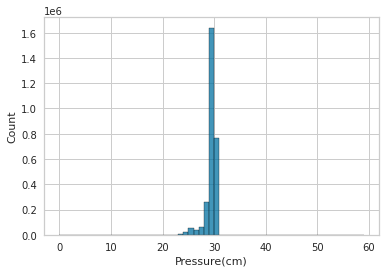

In [496]:
sns.histplot(df["Pressure(cm)"], bins=bins)
plt.show()

Well i couldn't do it better than this, but we can be sure, the pressure for almost all of the accident is 30 cm. 

In [497]:
df.rename(columns={"Visibility(mi)":"Visibility(km)"}, inplace=True)

In [498]:
df["Visibility(km)"] = df["Visibility(km)"] * 1.6

In [499]:
df_visibility = pd.DataFrame(df["Visibility(km)"].value_counts()).reset_index().rename(columns={"index":"Visibility(km)","Visibility(km)":"Number of accidents"})

In [500]:
df_visibility

,Visibility(km),Number of accidents
0,16.00,2286600
1,11.20,81729
2,14.40,70614
3,12.80,57329
4,8.00,55343
...,...,...
71,9.92,1
72,100.80,1
73,68.80,1
74,57.60,1


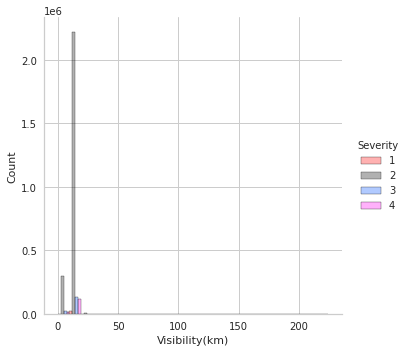

In [501]:
plot = sns.displot(df, x="Visibility(km)", hue="Severity", palette=["#FF0000", "#000000", "#0051FF", "#FF00F3"], alpha=0.3, multiple='dodge')

The overwhelming majority, almost 80% of the accidents occur when the visibility is around 15km. But there is one more peak which is close to 0.

In [502]:
df_wind_direction = pd.DataFrame(df["Wind_Direction"].value_counts()).reset_index().rename(columns={"index":"Wind_direction","Wind_Direction":"Number of accidents"})

In [503]:
df_wind_direction

,Wind_direction,Number of accidents
0,CALM,446837
1,S,174776
2,W,172717
3,WNW,148884
4,NW,145177
5,SSW,140797
6,WSW,134099
7,SW,132202
8,SSE,128907
9,NNW,127870


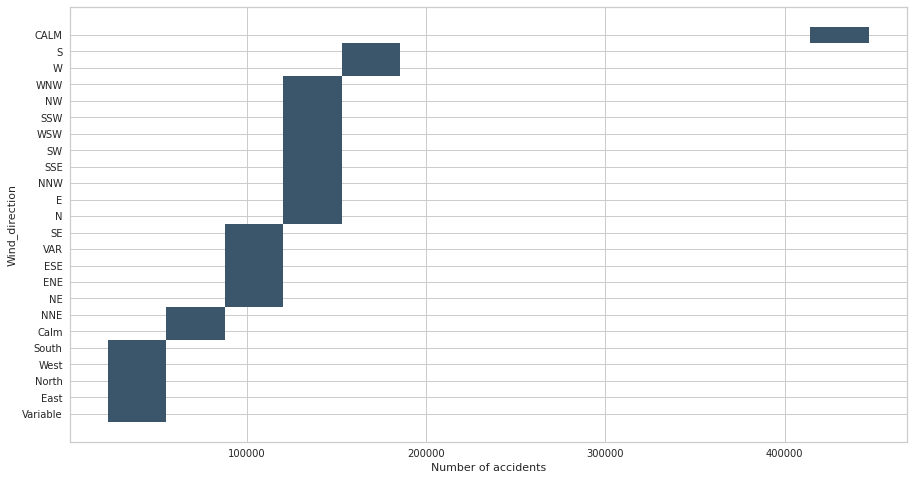

In [504]:
plt.figure(figsize=(15,8))
sns.histplot(df_wind_direction, y="Wind_direction", x="Number of accidents")
plt.show()

As we can see, paradoxically enough, most accidents occur at calm weather.

In [505]:
xticks = list(df["Wind_Direction"].unique())

<Figure size 1080x576 with 0 Axes>

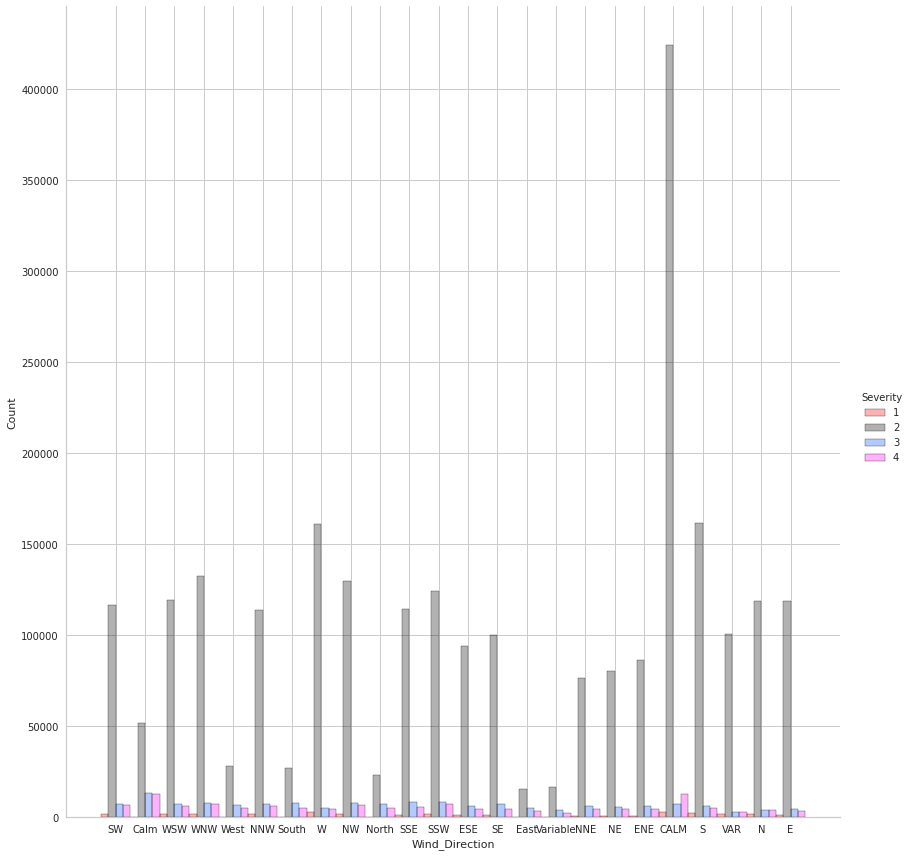

In [506]:
plt.figure(figsize=(15,8))
plot = sns.displot(df, x="Wind_Direction", hue="Severity", palette=["#FF0000", "#000000", "#0051FF", "#FF00F3"], alpha=0.3, multiple='dodge', height=12)
#plot.set_xticklabels(xticks, rotation=90, ha="right")
plt.show()

Another confirmation of the beforehand seen graph, most of the accidents happen during calm weather. But there is notably not a spike but kind of peak when there is W wind. 

In [507]:
df.rename(columns={"Wind_Speed(mph)":"Wind_Speed(km)"}, inplace=True)

In [508]:
df["Wind_Speed(km)"] = df["Wind_Speed(km)"] * 1.6

Once again, transforming the column to kilometers from miles.

In [509]:
df_wind_speed = pd.DataFrame(df["Wind_Speed(km)"].value_counts()).reset_index().rename(columns={"index":"Wind_Speed(km)","Wind_Speed(km)":"Number of accidents"})


In [510]:
bins = compute_histogram_bins(df_wind_speed["Wind_Speed(km)"], 100)

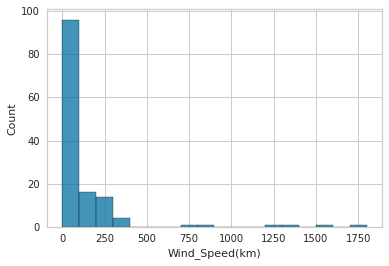

In [511]:
plot = sns.histplot(df_wind_speed, x="Wind_Speed(km)", bins=bins)

There are few outliers, but I will keep them in the plot, nevertheless they are in the dataset. More than 30% of the accidents occur within 0 - 10 km/h winds.

In [512]:
df_wind_speed = df_wind_speed[:10]

<AxesSubplot:xlabel='Wind_Speed(km)', ylabel='Number of accidents'>

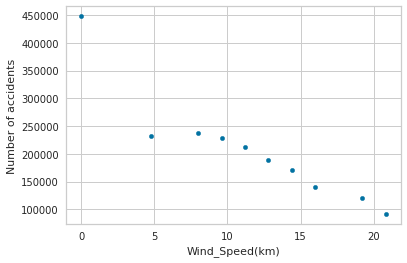

In [513]:
df_wind_speed.plot(x='Wind_Speed(km)', y='Number of accidents', kind='scatter')

As you can see, there is distinct spike at calm wind speed. I limited things, because the dataset is huge and it distorts important parts.

In [514]:
df.rename(columns={"Precipitation(in)":"Precipitation(cm)"},inplace=True)

In [515]:
df["Precipitation(cm)"] = df["Precipitation(cm)"] * 2.54

In [516]:
df_precipitation = pd.DataFrame(df["Precipitation(cm)"].value_counts()).reset_index().rename(columns={"index":"Precipitation(cm)","Precipitation(cm)":"Number of accidents"})

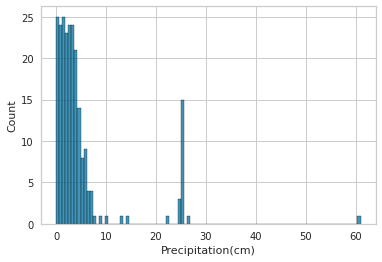

In [517]:
plot = sns.histplot(df_precipitation, x="Precipitation(cm)", bins=100)

So the precipitation clearly has a peak and a little smaller peak -> binomial distribution.
Almost all of the accidents occur when there is little to none precipitation.

In [518]:
df_precipitation_top = df_precipitation[:100]

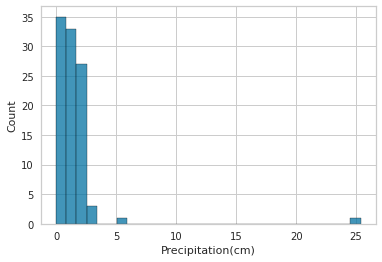

In [519]:
plot = sns.histplot(df_precipitation_top, x="Precipitation(cm)", bins=30)

The overwhelming majority of the precipitation is between zero and 4. Most of the accidents even occur when there is no precipitation.

In [520]:
df["Weather_Condition"].nunique()

127

In [521]:
df_weather_condition = pd.DataFrame(df["Weather_Condition"].value_counts()).reset_index().rename(columns={"index":"Weather_Condition","Weather_Condition":"Number of accidents"})

In [522]:
df_weather_condition = df_weather_condition[:50]

In [523]:
percentage = []
for x in df_weather_condition["Number of accidents"]:
    percentage.append(x / len(df["Severity"]))

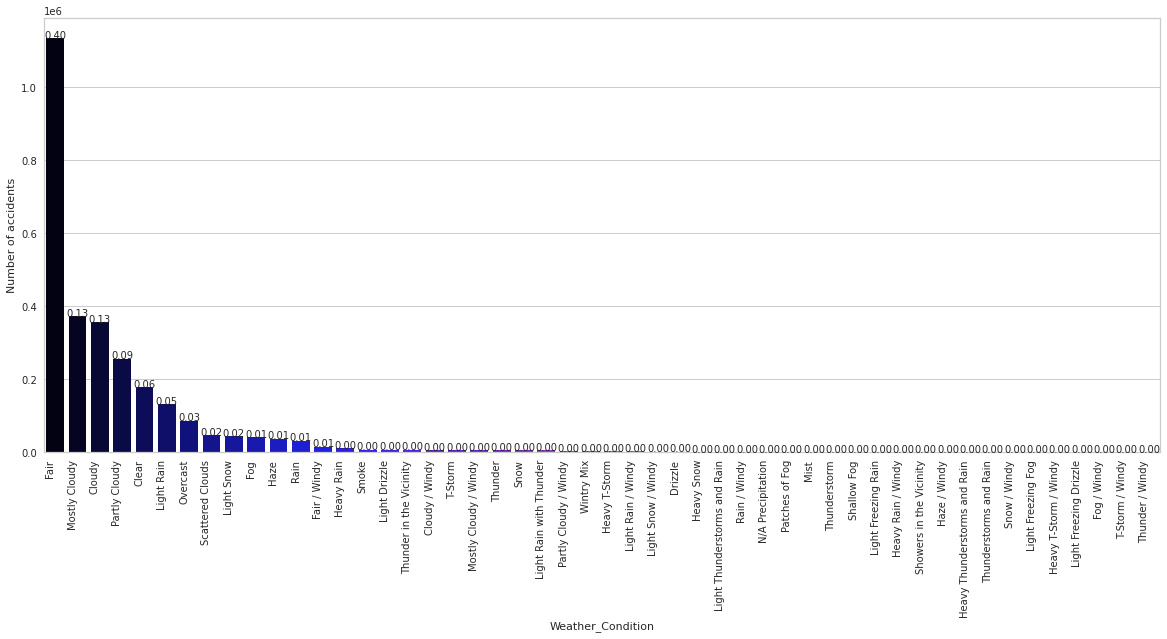

In [524]:
plt.figure(figsize=(20,8))
ax = sns.barplot(y=df_weather_condition["Number of accidents"], x=df_weather_condition["Weather_Condition"], palette="gnuplot2")
patches = ax.patches
for i in range(len(patches)):
    #plot.set_xticklabels(xticks, rotation=90, ha="right")
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.2f}'.format(percentage[i]), (x, y), ha='center')
ax.set_xticklabels(df_weather_condition["Weather_Condition"].values, rotation=90, ha="right")
plt.show()

* Most of the accidents(40%) happen when the weather is nice or fair.
* Top four weather conditions contains three conditons where the weather is cloudy.

In [525]:
df["Amenity"].value_counts()

False    2817352
True       27990
Name: Amenity, dtype: int64

In [526]:
false_perc = len([x for x in df["Amenity"] if x == False])

In [527]:
false_perc / len(df["Amenity"])

0.9901628697007249

In [528]:
true_perc = len([x for x in df["Amenity"] if x == True])

even though i don't really know what amenity means, false is 99%

In [529]:
df["Turning_Loop"].nunique()

1

In [530]:
df.drop("Turning_Loop",inplace=True,axis=1)

Dropping turning loop columns because it has only one value False.

In [531]:
for col in df.columns[29:41]:
    false_perc = len([x for x in df[col] if x == False])
    true_perc = len([x for x in df[col] if x == True])
    false = false_perc / len(df[col])
    true = true_perc / len(df[col])
    print(f"Col: {col}. | True percentage: {true:.{2}f}. | False percentage: {false:.{2}f}.")

Col: Amenity. | True percentage: 0.01. | False percentage: 0.99.
Col: Bump. | True percentage: 0.00. | False percentage: 1.00.
Col: Crossing. | True percentage: 0.07. | False percentage: 0.93.
Col: Give_Way. | True percentage: 0.00. | False percentage: 1.00.
Col: Junction. | True percentage: 0.10. | False percentage: 0.90.
Col: No_Exit. | True percentage: 0.00. | False percentage: 1.00.
Col: Railway. | True percentage: 0.01. | False percentage: 0.99.
Col: Roundabout. | True percentage: 0.00. | False percentage: 1.00.
Col: Station. | True percentage: 0.02. | False percentage: 0.98.
Col: Stop. | True percentage: 0.02. | False percentage: 0.98.
Col: Traffic_Calming. | True percentage: 0.00. | False percentage: 1.00.
Col: Traffic_Signal. | True percentage: 0.09. | False percentage: 0.91.


In the best case the true percentage is 10 which is very low to make a significant change

In [532]:
df.drop(["Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway","Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal"], axis=1, inplace=True)

In [533]:
df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(km)', 'Description', 'Street', 'Side',
       'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(C)', 'Wind_Chill(C)',
       'Humidity(%)', 'Pressure(cm)', 'Visibility(km)', 'Wind_Direction',
       'Wind_Speed(km)', 'Precipitation(cm)', 'Weather_Condition',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [534]:
df["Sunrise_Sunset"].value_counts()

Day      1813821
Night    1031521
Name: Sunrise_Sunset, dtype: int64

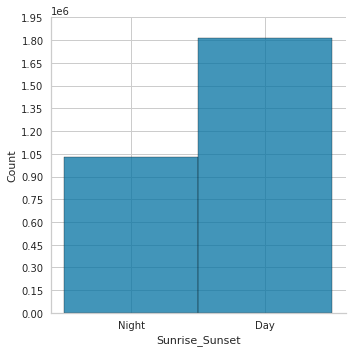

In [535]:
sns.displot(df["Sunrise_Sunset"])
plt.yticks(np.arange(0, 2_000_000, 150_000))
plt.show()

So, nearly half of the accidents occur during the day. I think that's because there are more people on the streets.

In [536]:
df["Civil_Twilight"].value_counts()

Day      1931106
Night     914236
Name: Civil_Twilight, dtype: int64

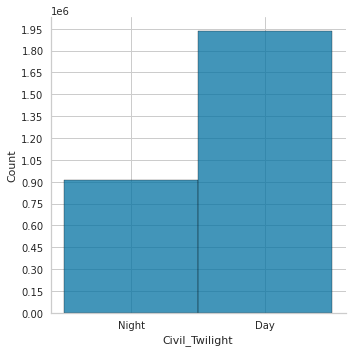

In [537]:
sns.displot(df["Civil_Twilight"])
plt.yticks(np.arange(0, 2_000_000, 150_000))
plt.show()

I don't know what civil twilight means, but it's happening during the day.

In [538]:
df["Nautical_Twilight"].value_counts()

Day      2065601
Night     779741
Name: Nautical_Twilight, dtype: int64

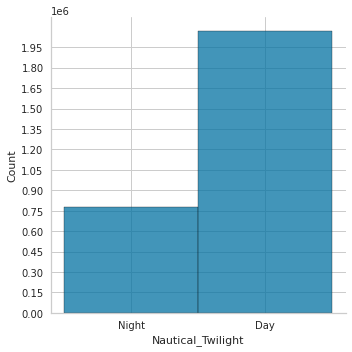

In [539]:
sns.displot(df["Nautical_Twilight"])
plt.yticks(np.arange(0, 2_000_000, 150_000))
plt.show()

As i stated before, this things occur during the day.

In [540]:
df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(km)', 'Description', 'Street', 'Side',
       'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(C)', 'Wind_Chill(C)',
       'Humidity(%)', 'Pressure(cm)', 'Visibility(km)', 'Wind_Direction',
       'Wind_Speed(km)', 'Precipitation(cm)', 'Weather_Condition',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [541]:
df["Astronomical_Twilight"].value_counts()

Day      2179234
Night     666108
Name: Astronomical_Twilight, dtype: int64

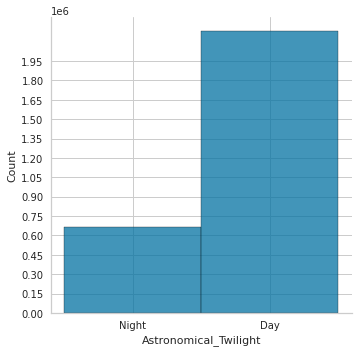

In [542]:
sns.displot(df["Astronomical_Twilight"])
plt.yticks(np.arange(0, 2_000_000, 150_000))
plt.show()

well..this thing is also during the day

In [543]:
df.drop("ID",axis=1,inplace=True)

In [544]:
df.drop(["Start_Time","End_Time","Description"],axis=1,inplace=True)

In [545]:
categorical_columns = df.select_dtypes(include=['object','bool']).columns

In [546]:
for col in categorical_columns:
    en = preprocessing.LabelEncoder()
    df[col] = en.fit_transform(df[col])

This is the final form of the dataset, it has nearly 3 million rows and 29 columns, but after some time, I will cut them down to manageable chunks in the lamest way possible.



In [547]:
y = df['Severity']
X = df.drop('Severity', axis=1)

Preparing the dataset for training and testing. Y in our case is the dependant value and it contains the labels which the models should be able to recognize and predict.

In [548]:
y.value_counts(normalize=True)

2    0.890224
3    0.054512
4    0.046108
1    0.009156
Name: Severity, dtype: float64

I want to see the distribution of the labels before making the training and the testing set, because in our case, the Severity column has high percentage of labels concentrated in just one value - 2. And I want to train/test the models using exactly this distribution, because the model could fit to another distribution which is not so important as this one -> bad models.

In [549]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=100, stratify=y)

In [550]:
X = X_train
y = y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=100, stratify=y)

This is the most outrageous thing in this notebook, I couldn't think of something else to do here. Due to the times from the models it became almost impossible for this botebook to finish executing cells for a day or much worse. I will try to find another way if I come up to dataset this big again. 

<AxesSubplot:>

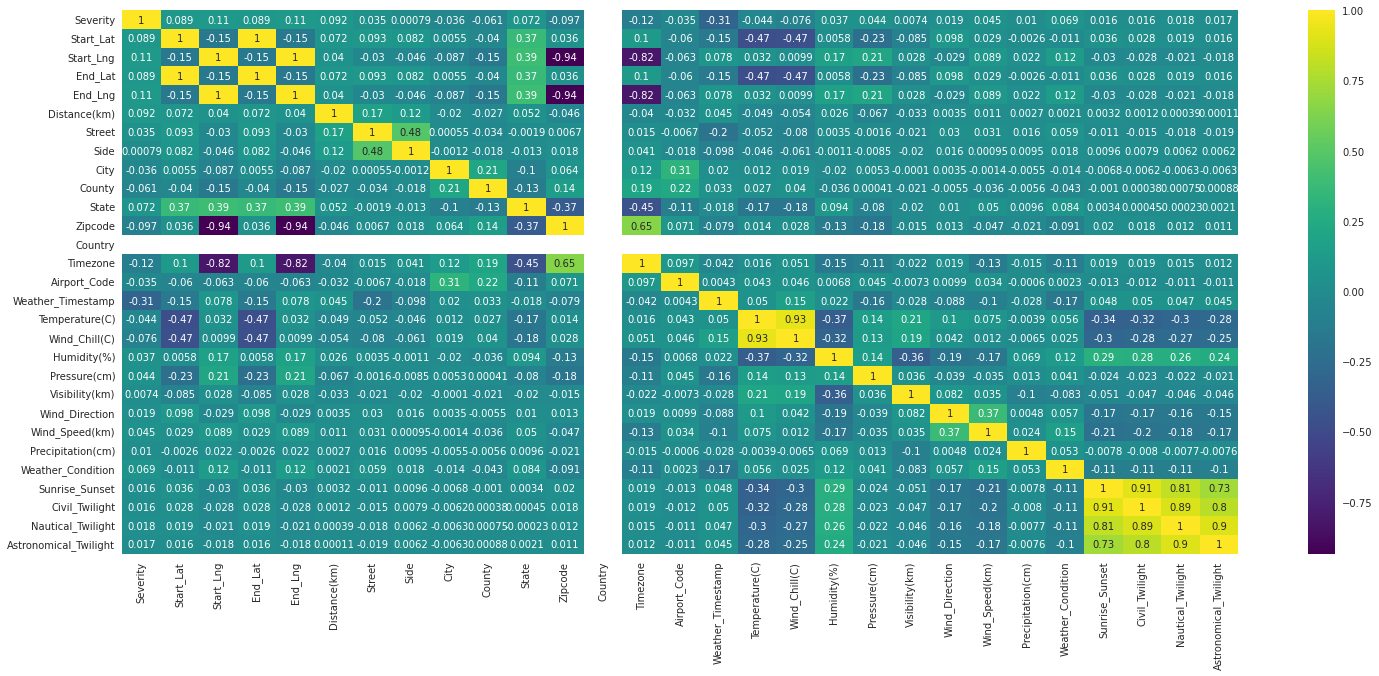

In [551]:
plt.figure(figsize=(25,10))
sns.heatmap(data= df.corr(), annot=True, cmap='viridis')

In [552]:
X_train_cols = X_train.columns

In [553]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(682881, 28) (170721, 28) (682881,) (170721,)


In [554]:
print(y_train.value_counts(normalize=True),"\n", y_test.value_counts(normalize=True))

2    0.890224
3    0.054512
4    0.046108
1    0.009157
Name: Severity, dtype: float64 
 2    0.890224
3    0.054510
4    0.046110
1    0.009155
Name: Severity, dtype: float64


I used the built in parameter of train_test_split - stratify, it retains the distribution of labels exactly like in the original dataset, which is perfect.

In [555]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Using the StandardScaler class which will transform the values in such way, that the model reaches convergence quickly. And overall, it's better to have our values scaled in some way or another.

I'm going to start with the simplest ones and work my way up of the complexity scale. Whatever the model is, I'm going to try to pull the best performance from it. I'm going to try different techniques and hopefully results will be good.

Since the project is centered around predicting the severity of the accident, the models will be predicting labels. In my case 1 - 4. So, the models will be classifiers and not regressors. The main difference between those two is that at the end of the training, the model will return a number in a range for example between 0 and 1 in the case of regressor. In the other case the model returns a label. The label method works for this type of projects. We have exactly four labels to predict.

So, let's explore the dataset

In [556]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(682881, 28) (170721, 28) (682881,) (170721,)


So in all, we have over 2.7 million rows for training and close to 90k for testing, but these training rows, might come down after I test them with the models.</br> 
Yes, they came down.

This is the model I'm going to be using right now, logistic regression, it might be the simplest one, but we'll have to see the results of the others first

<img src="https://miro.medium.com/max/460/1*klFuUpBGVAjTfpTak2HhUA.png" style="width:200px height:200px">

I'm going to start with the default model and change nothing in it to see the performance of the default model

In [557]:
default_linear_model = LogisticRegression(n_jobs=-1, solver="sag", tol=0.0001)

I'm using a slightly modified default LogisticRegression because of the rows that are being fed to the model. N_jobs could be used to utilize all the processors in the computer. Solver is sag, because it converges faster than other solvers for large datasets and tol is when you are close enough to a desired outcome, the model stops searching for minimum and thus, the algorithms is faster, maybe the results will suffer, but in order to run this notebook in a timely manner, these are the things that should be sacrificed.

In [558]:
%%time
clf = default_linear_model.fit(X_train, y_train)

CPU times: user 1min 36s, sys: 80.5 ms, total: 1min 36s
Wall time: 1min 36s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [559]:
print("adsfadsfa")

adsfadsfa


In [560]:
result_labels = clf.predict(X_test)

In [561]:
print(classification_report(y_test, result_labels))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1563
           2       0.90      0.99      0.94    151980
           3       0.31      0.07      0.11      9306
           4       0.55      0.07      0.12      7872

    accuracy                           0.89    170721
   macro avg       0.44      0.28      0.29    170721
weighted avg       0.84      0.89      0.85    170721



So, let's start with the first label which is One. As you can see, there is nothing about it, but the support is 1563, which means that from all of the 1563 examples, the model did not predicted class 1 at all! This is kind of bad, but the model is the simplest, maybe it did not understand the data well or it's because there are <1% of data for this class and it gets overshadowed by the others. </br>
    * The second class has the majority of the predictions and support. Overall it is the best as the metrics are between 90 and 99 which is good, but after all, the algorithm did have the most to learn about it and it became so good at it, that it forgot about the first class. As we know, the gradient descent is greedy algorithm and it'll exploit those things just to react to better performance. The fscore is not good either. </br>
    * The third class has a precision of .31 which is kind of bad. The recall is even worse at .07 which could mean that the algorithm did not understood it well enough. There might be few training examples. </br>
    * The fourth class is almost the same as the third, but its precision is higher. 

In [562]:
cv_results = cross_validate(clf, X_train, y_train, cv=3)

In [563]:
cf = confusion_matrix(y_test, result_labels)

In [564]:
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [565]:
cv_results['test_score']

array([0.88732005, 0.88714871, 0.88717068])

So, not matter how the training data is split, the accuracy is still the same, in other words, it sill predicting only the second class.

In [566]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.0f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.0f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.show()

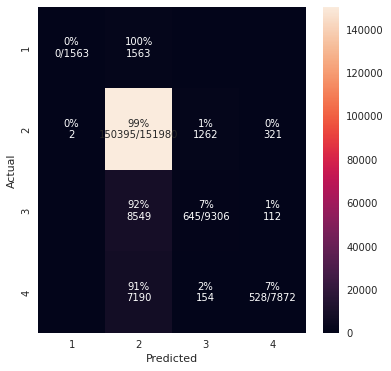

In [567]:
cm_analysis(y_test, result_labels, [1,2,3,4], figsize=(6,6))

In [568]:
def log_odds(model):
  log_odds = [np.exp(x)/(1 + np.exp(x)) for x in model.coef_[0]]
  log_odds = np.exp(model.coef_[0])
  default_linear_model.score(X_test, y_test)
  some_model = pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
  some_model.plot()

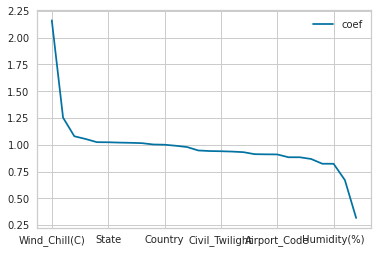

In [569]:
log_odds(clf)

In [570]:
ransac = RANSACRegressor(
    base_estimator=default_linear_model,
    max_trials=3,
    min_samples=0.25
)

In [571]:
ransac.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


RANSACRegressor(base_estimator=LogisticRegression(n_jobs=-1, solver='sag'),
                max_trials=3, min_samples=0.25)

In [572]:
len(X)

853602

In [573]:
labels = ransac.predict(X_test)

In [574]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1563
           2       0.89      1.00      0.94    151980
           3       0.39      0.04      0.07      9306
           4       0.60      0.06      0.10      7872

    accuracy                           0.89    170721
   macro avg       0.47      0.27      0.28    170721
weighted avg       0.85      0.89      0.85    170721



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [576]:
logreg = LogisticRegression()
logreg.fit(X_train_pca, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [577]:
labels = logreg.predict(X_test)
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           1       0.01      0.00      0.01      1563
           2       0.89      0.98      0.94    151980
           3       0.17      0.03      0.05      9306
           4       0.06      0.01      0.01      7872

    accuracy                           0.88    170721
   macro avg       0.28      0.26      0.25    170721
weighted avg       0.81      0.88      0.84    170721



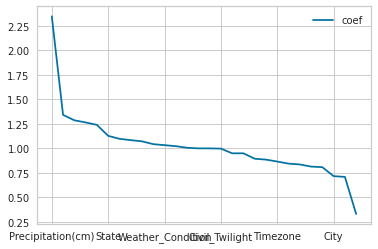

In [578]:
log_odds(logreg)

Hmm..the model is recognizing the majority of the class, but miscategorizes the minority of the classes. Let's fit the data again but with a different penalty, the default for logistic regression here in sklearn is L2. Let's try with L1

In [579]:
l1_logistic_regression = LogisticRegression(penalty="l1", solver="liblinear", n_jobs=-1, tol=0.001)

In [580]:
%%time
l1_logistic = l1_logistic_regression.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1526: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs))
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


CPU times: user 56 s, sys: 1.56 s, total: 57.6 s
Wall time: 57.7 s


31494

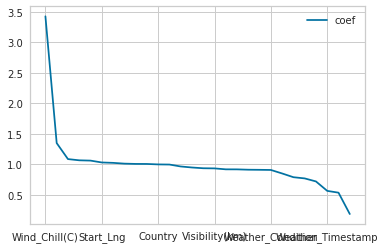

In [581]:
result_labels = l1_logistic.predict(X_test)
log_odds(l1_logistic)
del l1_logistic
gc.collect()

In [582]:
print(classification_report(y_test, result_labels))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1563
           2       0.90      0.99      0.94    151980
           3       0.30      0.06      0.10      9306
           4       0.54      0.07      0.12      7872

    accuracy                           0.89    170721
   macro avg       0.44      0.28      0.29    170721
weighted avg       0.84      0.89      0.85    170721



Once again, the L1 did not change much the predictive power of the model. They are predtty much identical with the L2 normalization.
</br>
</br>

So, other thing that we could do is to use C hyper parameter of logistic regression. It is used to prevent overfitting to the dataset.

In [583]:
c_logistic_regression = LogisticRegression(n_jobs=-1, tol=0.001, C=0.001)

In [584]:
%%time
clf = c_logistic_regression.fit(X_train, y_train)

CPU times: user 167 ms, sys: 448 ms, total: 615 ms
Wall time: 25.5 s


In [585]:
labels = clf.predict(X_test)

In [586]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1563
           2       0.90      0.99      0.94    151980
           3       0.31      0.06      0.10      9306
           4       0.55      0.06      0.11      7872

    accuracy                           0.89    170721
   macro avg       0.44      0.28      0.29    170721
weighted avg       0.84      0.89      0.85    170721



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Again, nothing really changes, let's up the C parameter.

In [587]:
def grid_search(C):
    c_logistic_regression = LogisticRegression(n_jobs=-1, tol=0.001, C=C)
    clf = c_logistic_regression.fit(X_train, y_train)
    labels = clf.predict(X_test)
    print(classification_report(y_test, labels))
    log_odds = [np.exp(x)/(1 + np.exp(x)) for x in c_logistic_regression.coef_[0]]
    log_odds = np.exp(default_linear_model.coef_[0])

    c_logistic = pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)


    c_logistic.plot()

    del c_logistic_regression
    del clf
    del labels
    gc.collect()

In [588]:
#grid_search(1)

Nothings changed. The most prevalent column for the model to make its prediction appears to be wind chill.

In [589]:
#grid_search(100)

Same here, nothing's really changed.

In [590]:
#grid_search(10_000)

Well, it appears that C parameter won't do any positive for the model.
<h3>
    kaji zashto
<h3>

In [591]:
def plot_polynomial(degree):
    poly_inputs = PolynomialFeatures(degree=degree)
    poly_X_train, poly_X_test, poly_y_train, poly_y_test = train_test_split(X_train, y_train, test_size=0.8, stratify=y_train)
    if degree > 2:
        poly_X_train, poly_X_test, poly_y_train, poly_y_test = train_test_split(X_train, y_train, test_size=0.95, stratify=y_train)
    poly_inputs_fit = poly_inputs.fit_transform(poly_X_train)
    poly_inputs_test = poly_inputs.fit_transform(poly_X_test)
    poly_logistic = LogisticRegression(n_jobs=-1, tol=0.01)
    clf = poly_logistic.fit(poly_inputs_fit, poly_y_train)
    labels = clf.predict(poly_inputs.fit_transform(poly_X_test))
    log_odds = [np.exp(x)/(1 + np.exp(x)) for x in clf.coef_[0]]
    log_odds = np.exp(default_linear_model.coef_[0])

    poly_logistic = pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)


    poly_logistic.plot()
    
    print(classification_report(poly_y_test, labels))
    del clf
    del labels
    gc.collect()

So let's change the input variables a bit.

For the first time we have class 1 predicted. The precision is kind of acceptable, but the recall is terrible. That means that we are misscategorising almost all of the class one predictions. That is the case for all the classes, except class 2, which has the most rows.

Continuing with degree 3 and I will stop here, because the features will again become so much that it's taking a toll on the computer and our time.

              precision    recall  f1-score   support

           1       0.74      0.11      0.19      5002
           2       0.91      0.99      0.95    486334
           3       0.50      0.13      0.21     29780
           4       0.61      0.19      0.29     25189

    accuracy                           0.90    546305
   macro avg       0.69      0.36      0.41    546305
weighted avg       0.87      0.90      0.87    546305



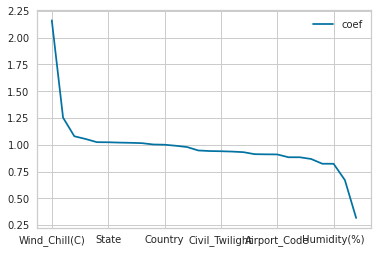

In [592]:
plot_polynomial(2)

In [593]:
#plot_polynomial(3)
#Due to the fact that this alone takes more than 15GB of Ram, I'm going to comment it for the sake of completing the notebook.

Upping the degree of polynomial features does not yield better results, the opposite, the first class' precision is worse. Maybe there are only a few training examples or the model is just too simple to grasp the complexity of the classes that are not 2.

In [594]:
stratified_k_fold = StratifiedKFold(n_splits=5)

I'm using StratifiedKFold to see whether there is a optimal training and testing ranges.

In [595]:
pred_test_full =0
cv_score =[]
i=1

In [596]:
for train_index, test_index in stratified_k_fold.split(X,y):
    print('{} of KFold {}'.format(i,stratified_k_fold.n_splits))
    X_train_str, X_test_str = X.iloc[train_index], X.iloc[test_index]
    y_train_str, y_test_str = y.iloc[train_index], y.iloc[test_index]
    y_test_str = label_binarize(y_test_str, classes=[1,2,3,4])
    
    default_linear_model.fit(X_train_str, y_train_str)
    
    pred_test = default_linear_model.predict(X_test_str)
    
    score = roc_auc_score(y_test_str,pred_test.reshape(-1,1), multi_class="ovo")
    print('ROC AUC score:',score)
    i += 1

1 of KFold 5


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


ROC AUC score: 0.49830336135447334
2 of KFold 5


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


ROC AUC score: 0.498329953829874
3 of KFold 5


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


ROC AUC score: 0.4983802030066743
4 of KFold 5


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


ROC AUC score: 0.49827970465307375
5 of KFold 5


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


ROC AUC score: 0.49833290966380345


This was underwhelming, however the algorithm divides the training set and the test set, the prediction power of the default model is much worse with KFold than training on the whole dataset(not the whole, but big enough for the laptop that i have). Maybe I did something wrong with it.

So, know I'm going to plot auc curve to see how it is for the best model so far, LogisticRegression with PolynomialFeatures(2).

I'm going to continue with trees. They don't use gradient descent and are like if else. The goal is to divide the data in such way that the algorithm uses the least amount of questions.

<img src="https://static.javatpoint.com/tutorial/machine-learning/images/decision-tree-classification-algorithm.png" style="width:200px height:200px">

We measure the impurity/entropy between the node and its parents and if we have entropy which is close to zero(hopefully) we could say that the training has finished.

In [597]:
decision_tree_default = DecisionTreeClassifier()

In [598]:
%%time
clf = decision_tree_default.fit(X_train, y_train)

CPU times: user 39.6 s, sys: 4 ms, total: 39.6 s
Wall time: 39.7 s


In [599]:
y_pred = clf.predict(X_test)

In [600]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8749538721071222


In [601]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.46      0.53      0.49      1563
           2       0.94      0.93      0.94    151980
           3       0.37      0.39      0.38      9306
           4       0.36      0.40      0.38      7872

    accuracy                           0.87    170721
   macro avg       0.53      0.56      0.55    170721
weighted avg       0.88      0.87      0.88    170721



This is the performance of the default decision tree classifier. Apart from the second class, the other classes are kind of random predicted.

In [602]:
importance = clf.feature_importances_

In [604]:
indices = np.argsort(importance)[::-1][:20]

In [605]:
len(indices)

20

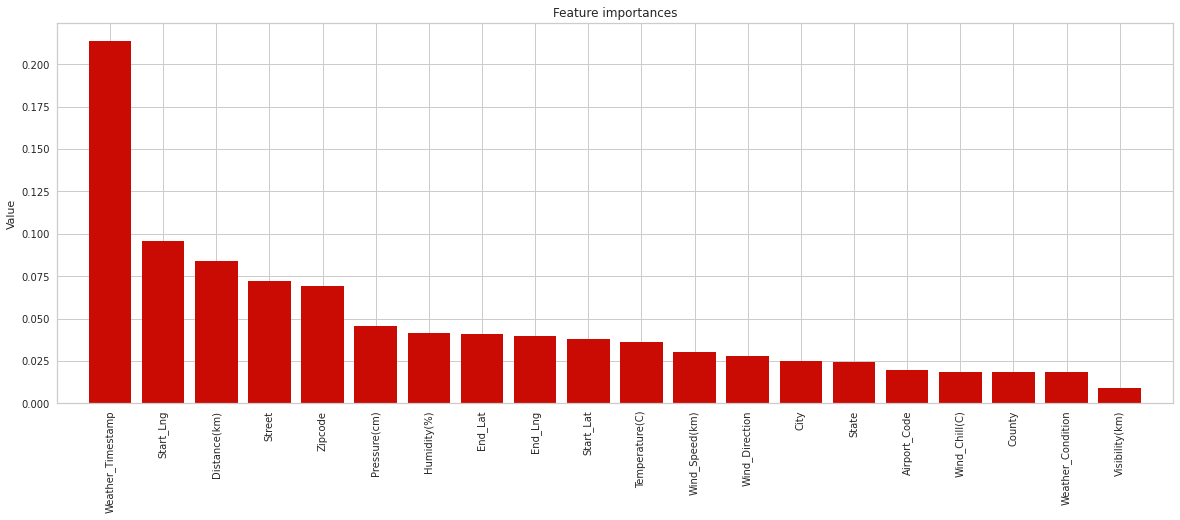

In [607]:
plt.figure(figsize=(20,7))
plt.title("Feature importances")
plt.bar(range(len(indices)), importance[indices], color="r", align="center")
plt.xticks(range(len(indices)), X_train_cols[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.ylabel("Value")
plt.show()

In [608]:
decision_tree_default = DecisionTreeClassifier(max_depth=3)

In [609]:
clf = decision_tree_default.fit(X_train, y_train)

In [610]:
y_pred = clf.predict(X_test)

In [611]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1563
           2       0.89      1.00      0.94    151980
           3       0.00      0.00      0.00      9306
           4       0.00      0.00      0.00      7872

    accuracy                           0.89    170721
   macro avg       0.22      0.25      0.24    170721
weighted avg       0.79      0.89      0.84    170721



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [612]:
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz

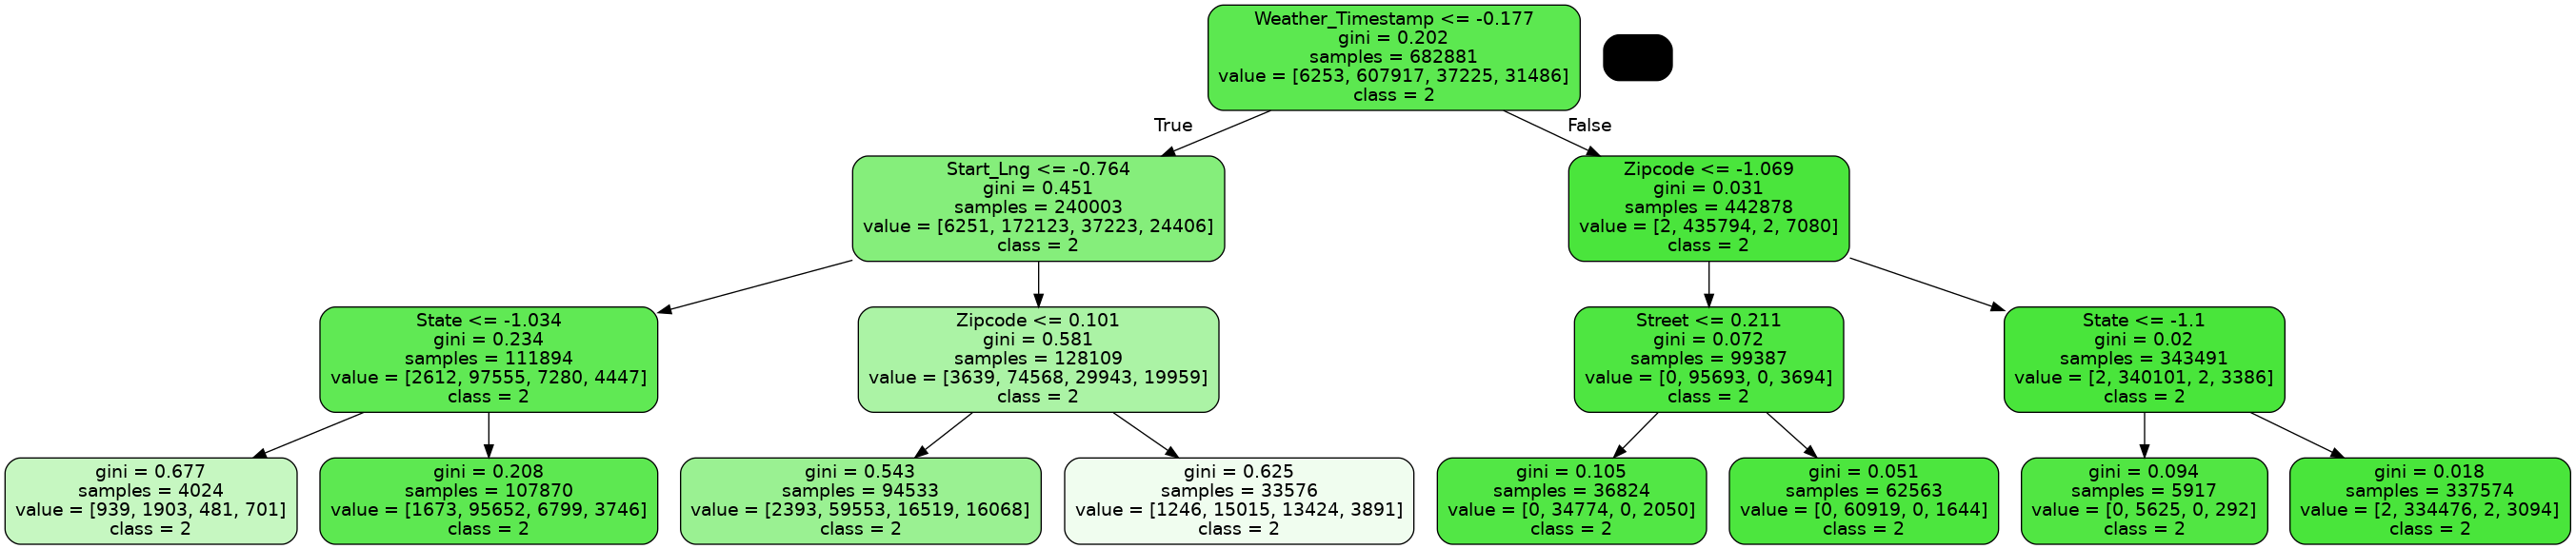

In [613]:
dot_data = StringIO() 
export_graphviz(clf, filled=True, out_file=dot_data, rounded=True,  feature_names=X.columns, class_names=["1","2","3","4"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png(), width=1000)

Clearly the tree overfits to the second class. The model learned that by predicting only the second class correctly, it will yield good enough results...and this is exactly what it did. 
I'm going to try with some hyperparameters changed and then proceed with 


In [614]:
params = {'max_depth': [2,4,6],
         'min_samples_split': [1,2,3],
         'min_samples_leaf': [1,2]}

In [615]:
clf = DecisionTreeClassifier()

In [616]:
gcv = GridSearchCV(estimator=clf,param_grid=params)

In [617]:
%%time
gcv.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 254, in fit
    % self.min_samples_split
ValueError: min_samples_split must be an integer greater than 1 or a float i

CPU times: user 8min 17s, sys: 64.2 ms, total: 8min 17s
Wall time: 8min 18s


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [1, 2, 3]})

In [618]:
model = gcv.best_estimator_

In [619]:
model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=2)

In [620]:
y_train_pred = model.predict(X_train)

In [621]:
y_test_pred = model.predict(X_test)

In [622]:
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 0.9025393882682341
Test score 0.9027301855073483


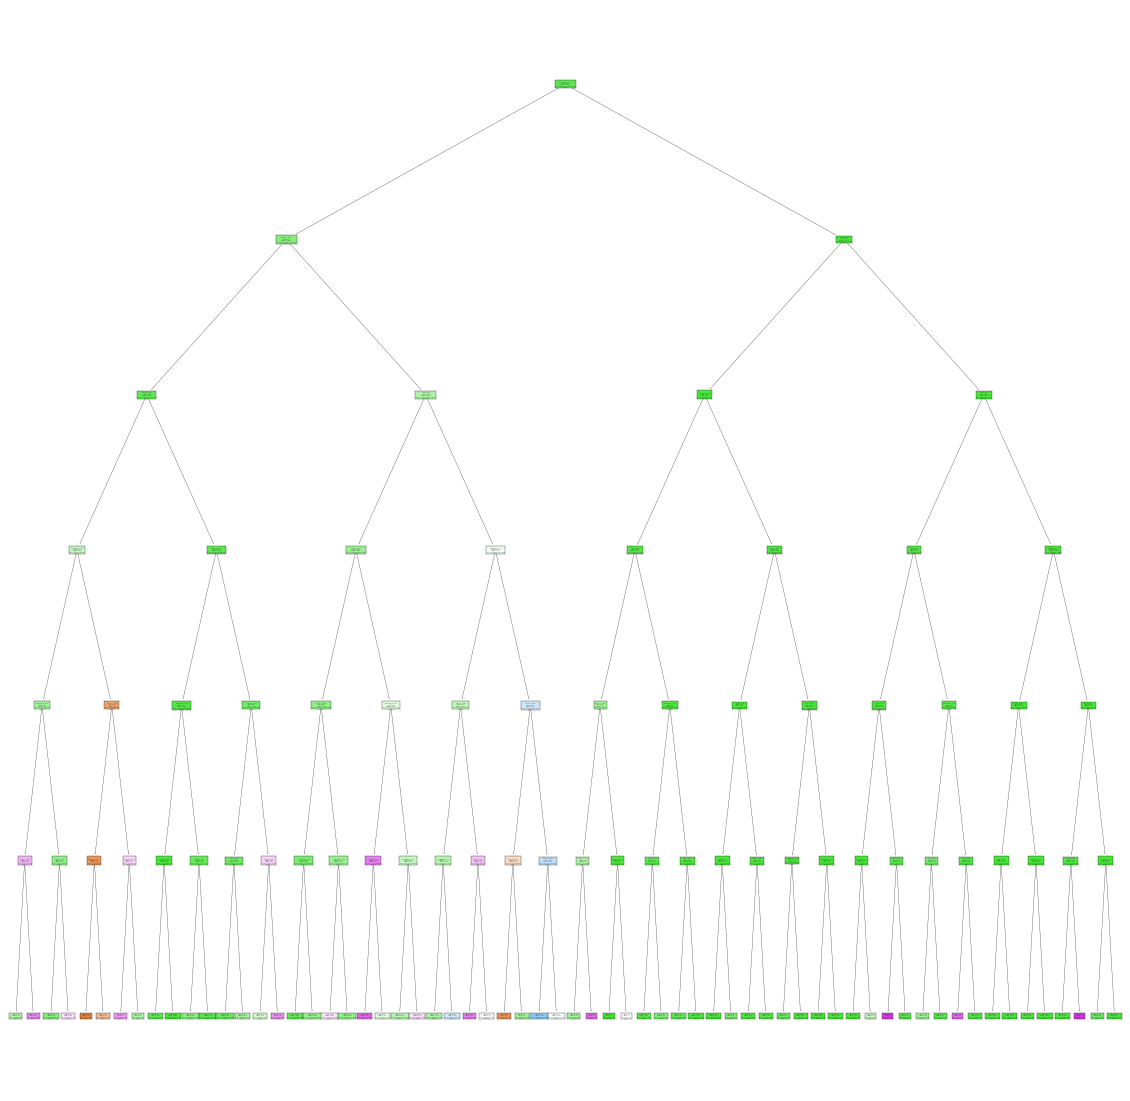

In [623]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ["1","2","3","4"]
plot_tree(model,feature_names=features,class_names=classes,filled=True)
plt.show()

In [624]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.80      0.26      0.39      1563
           2       0.92      0.98      0.95    151980
           3       0.51      0.23      0.32      9306
           4       0.55      0.30      0.39      7872

    accuracy                           0.90    170721
   macro avg       0.70      0.44      0.51    170721
weighted avg       0.88      0.90      0.89    170721



So, as expected the model did not so bad. It even got class 1, 3 and 4 right(somewhat). It still keeps missing the 1, 3, and 4 classes, which i'm going to try to resolve somehow. Either the model is too simple of just the data is not so well seperable.
</br>

The best model is this, I'm going to change the criterion on it and see whether the predictions are better.

In [625]:
model

DecisionTreeClassifier(max_depth=6, min_samples_leaf=2)

In [626]:
model.criterion

'gini'

In [627]:
clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, criterion="entropy")

Going to try with a different criterion, maybe that will yield some better results.

In [628]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2)

In [629]:
labels = clf.predict(X_test)

In [630]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [631]:
del clf
gc.collect()

25814

In [632]:
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 0.9002857013154562
Test score 0.9004340415063173


In [633]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.80      0.27      0.40      1563
           2       0.92      0.98      0.95    151980
           3       0.51      0.09      0.15      9306
           4       0.53      0.36      0.43      7872

    accuracy                           0.90    170721
   macro avg       0.69      0.42      0.48    170721
weighted avg       0.88      0.90      0.88    170721



Pretty much the same, except for class 3, which recall dropped to a much lower one.

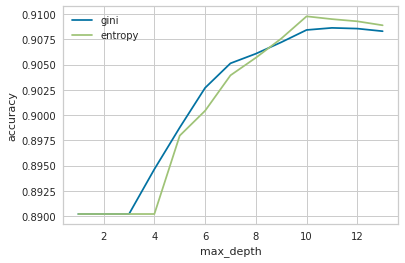

In [634]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,14):
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
    
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    
    max_depth.append(i)
    d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
     'acc_entropy':pd.Series(acc_entropy),
     'max_depth':pd.Series(max_depth)})
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

It's not that big of a difference between depths, but it's noticeable that with increasing the depth, the model is becomming better until a point aroun 10-12 is reached, then the performance of the model goes down.

In [635]:
del dtree
gc.collect()

23

In [636]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

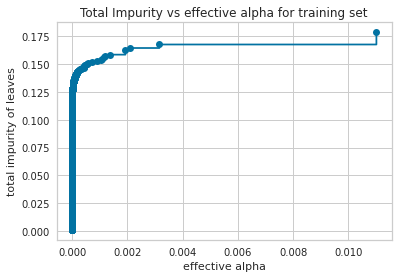

In [637]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

With the increasing of alpha, the tree gets more pruned and total impurity of the leaves increases.

<img src="https://scaler.com/topics/images/bagging-and-boosting_thumbnail.webp" style="width:200px height:100px">

In [638]:
estimator_range = [2,4,6] 

In [639]:
models = []
scores = []

for n_estimators in estimator_range:

    clf = BaggingClassifier(n_estimators = n_estimators, random_state = 22)

    clf.fit(X_train, y_train)

    models.append(clf)
    scores.append(accuracy_score(y_true = y_test, y_pred = clf.predict(X_test)))
    print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           1       0.38      0.63      0.47      1563
           2       0.93      0.97      0.95    151980
           3       0.43      0.27      0.33      9306
           4       0.58      0.24      0.34      7872

    accuracy                           0.89    170721
   macro avg       0.58      0.53      0.52    170721
weighted avg       0.88      0.89      0.88    170721

              precision    recall  f1-score   support

           1       0.47      0.59      0.53      1563
           2       0.93      0.97      0.95    151980
           3       0.48      0.31      0.38      9306
           4       0.56      0.35      0.43      7872

    accuracy                           0.90    170721
   macro avg       0.61      0.56      0.57    170721
weighted avg       0.89      0.90      0.89    170721

              precision    recall  f1-score   support

           1       0.53      0.58      0.55      1563
           2       0.

There could be seen slight improvement as the n_estimators go up, but due to the fact that this is machine with limited RAM and we are with limited time, 6 is the max.

In [640]:
del clf
gc.collect()

3401

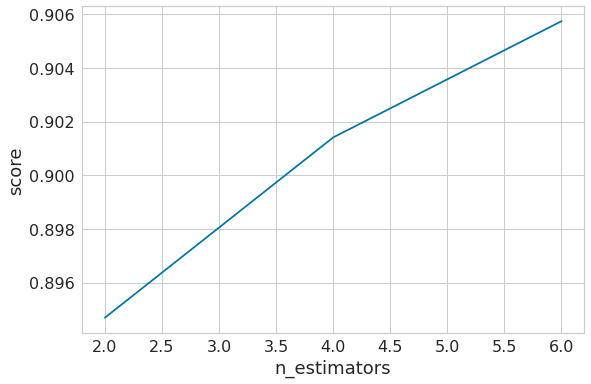

In [641]:
plt.figure(figsize=(9,6))
plt.plot(estimator_range, scores)

plt.xlabel("n_estimators", fontsize = 18)
plt.ylabel("score", fontsize = 18)
plt.tick_params(labelsize = 16)

plt.show() 

The higher the number of estimators are, the more accurate the result is. But it's not accurate by much, I wanted to try some other number of estimators, but 6 is okay and it doesn't take too much time

Now I'm going to try with Boosting classifier. As the name sugests it's going to be boosting something. It's boosting the previous score that a model achieved by fitting another model to the dataset on which the previous score was bad.

In [642]:
abc = AdaBoostClassifier()

In [643]:
%%time
parameters = {
    'n_estimators': [1, 2, 3, 4, 5, 6, 7]
}
clf = GridSearchCV(abc, parameters, cv=5, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 20.6 s, sys: 1.03 s, total: 21.7 s
Wall time: 2min 24s


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7]})

In [644]:
clf.best_estimator_

AdaBoostClassifier(n_estimators=7)

The best estimator is the one with the highest number of estimators.

In [645]:
clf.best_score_

0.8910791179897941

In [646]:
labels = clf.predict(X_test)

In [647]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           1       0.70      0.23      0.35      1563
           2       0.89      1.00      0.94    151980
           3       0.00      0.00      0.00      9306
           4       0.00      0.00      0.00      7872

    accuracy                           0.89    170721
   macro avg       0.40      0.31      0.32    170721
weighted avg       0.80      0.89      0.84    170721



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [648]:
del clf
gc.collect()

3563

The best score is a little bit worse than the bagging classifier but if I trained them on the cloud, it might be different.</br>
Maybe try something different with the Boosting algorithm, like changing the learning rate.

In [649]:
abc = AdaBoostClassifier()

In [650]:
parameters = {
    'learning_rate': [5]
}
clf = GridSearchCV(abc, parameters, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [5]})

In [651]:
labels = clf.predict(X_test)

gc.collect()

135

In [652]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1563
           2       0.85      0.00      0.00    151980
           3       0.15      1.00      0.26      9306
           4       0.02      0.22      0.03      7872

    accuracy                           0.06    170721
   macro avg       0.25      0.30      0.07    170721
weighted avg       0.76      0.06      0.02    170721



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Well, that was bad, the learning rate is too high, I will try with lower.

In [653]:
parameters = {
    'learning_rate': [0.5]
}
clf = GridSearchCV(abc, parameters, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5]})

In [654]:
labels = clf.predict(X_test)
del clf
gc.collect()

135

In [655]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           1       0.67      0.11      0.19      1563
           2       0.90      0.98      0.94    151980
           3       0.36      0.17      0.23      9306
           4       0.17      0.02      0.03      7872

    accuracy                           0.88    170721
   macro avg       0.53      0.32      0.35    170721
weighted avg       0.84      0.88      0.85    170721



In [656]:
parameters = {
    'learning_rate': [0.15]
}
clf = GridSearchCV(abc, parameters, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.15]})

In [657]:
labels = clf.predict(X_test)
del clf
gc.collect()

135

In [658]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           1       0.88      0.09      0.16      1563
           2       0.89      1.00      0.94    151980
           3       0.49      0.01      0.02      9306
           4       0.00      0.00      0.00      7872

    accuracy                           0.89    170721
   macro avg       0.56      0.27      0.28    170721
weighted avg       0.83      0.89      0.84    170721



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we can see, lowering the learning rate, yields more accurate results, I could do this in a GridSearch to find the best learning rate, but due to the fact I haven't transferred the notebook to a cloud, I'm going to stick with this one.

Now I'm going to try with the VotingClassifier.

In [659]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)

In [660]:
clf2 = DecisionTreeClassifier()

In [661]:
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)], voting='hard')

In [662]:
eclf1 = eclf1.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [663]:
labels = eclf1.predict(X_test)
del eclf1
del clf2
del clf1
gc.collect()

100

In [664]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           1       0.34      0.52      0.41      1563
           2       0.90      0.99      0.94    151980
           3       0.40      0.04      0.08      9306
           4       0.76      0.05      0.09      7872

    accuracy                           0.89    170721
   macro avg       0.60      0.40      0.38    170721
weighted avg       0.86      0.89      0.85    170721



Surprisingly enough, it catches the first class kind of randomly, but it's different from single digit recall.

I'll try with StackingClassifier next. It stacks N individual models and in the end, the data goes through one last model to yield the output.

In [665]:
estimators = [("dt",DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2)),
              ("dt2",DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2))]

In [666]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [667]:
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=2)),
                               ('dt2',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=2))],
                   final_estimator=LogisticRegression())

In [668]:
labels = clf.predict(X_test)
del clf
gc.collect()

125

In [669]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           1       0.80      0.27      0.40      1563
           2       0.93      0.96      0.95    151980
           3       0.41      0.34      0.37      9306
           4       0.53      0.36      0.43      7872

    accuracy                           0.90    170721
   macro avg       0.67      0.48      0.54    170721
weighted avg       0.88      0.90      0.89    170721



Not so bad, but the model keeps missing the first class, maybe there is a bias that the model did not catch what it needed to. </br>
Maybe the models are not complex enough, they are pretty simple in general.

I'm going to try something with GradientBoostingClassifier.

In [670]:
clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.2,max_depth=4, random_state=0).fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
labels = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, labels))

I could play with the hyperparameters of the GradientBoostingClassifier but it will take me many hours to get something that will work fine. 

From trees, we're going to continue with forests. They consist of many decision trees.

In [ ]:
clf = RandomForestClassifier()

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
plot_feature_importance(clf.feature_importances_,X_train_cols,'Random Forest')

In [ ]:
labels = clf.predict(X_test)
del clf
gc.collect()

In [ ]:
print(classification_report(y_test, labels))

So far, this is the best model I think, although there are mistakes and once again, maybe the model is not complex enough to take into account all the classes or the data is just not good separated, but it's pretty good result knowing what the other models did.

In [ ]:
rf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=10,
           max_features=5, max_leaf_nodes=5,
           min_samples_leaf=1, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
labels = rf.predict(X_test)
plot_feature_importance(rf.feature_importances_,X_train_cols,'Random Forest')
del rf
gc.collect()

In [ ]:
print(classification_report(y_test, labels))

I tried this hyperparameters from the internet, and yes, they don't really work well.

In [ ]:
rfc_50 = RandomForestClassifier(n_estimators=50, random_state=0)

In [ ]:
rfc_50.fit(X_train, y_train)

In [ ]:
labels = rfc_50.predict(X_test)
plot_feature_importance(rfc_50.feature_importances_,X_train_cols,'Random Forest')
del rfc_50
gc.collect()

In [ ]:
print(classification_report(y_test, labels))

I'm going to continiue with the thing that is pushing the Artificial Intelligence to new heights, deep learning. In particular, I'm going to have a one ordinary model with Dense/Linear layers and one with Recurrent ones. They will server different purposes. As we'll see the one with Dense layers, does not perform much better than the ones beforehand.

<img src="https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_01_03-DeepNeuralNetwork-WHITEBG.png">

In [ ]:
y_train = y_train - 1

In [ ]:
y_test = y_test - 1

In [ ]:
def neural_network(hidden_dim, dropout, batch_size, epochs):
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(hidden_dim, activation='relu', kernel_regularizer=regularizers.L2(0.001))(inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(hidden_dim, activation='relu', kernel_regularizer=regularizers.L2(0.001))(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(hidden_dim, activation='relu', kernel_regularizer=regularizers.L2(0.001))(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
    )
    
    history = model.fit(
    X_train,
    y_train,
    validation_split=0.4,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
            )
        ]
    )
    
    print("Test Accuracy:", model.evaluate(X_test, y_test, verbose=0)[1])
    
    labels = model.predict(X_test)
    
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
    
    labels = np.argmax(labels, axis=1)
    
    print(classification_report(y_test, labels))

In [ ]:
neural_network(32, 0.3, 32, 3)

So, I've used deep learning to see if the model could predict the right things. Unfortunately it can't(for the most part). It uses gradient descent and it's a greedy algorithm, it's going in the direction of the most amount of (something). Therefore it learned that only by predicting the second class right, it could yield some good percent right and it could sticked to it. I'm going to try to change the hyperparameters a little bit and see if they could make some change.

In [ ]:
_ = neural_network(128, 0.3, 16, 3)

Well, it got a little bit better, let's try one last model

In [ ]:
_ = neural_network(128, 0.5, 18, 3)

This one is kind of horrible at predicting the classes, except the second one.

Lastly, I'm going to use LSTMs for predicting the classes.

<img src="https://www.iarai.ac.at/wp-content/uploads/2021/02/MC-LSTM.jpg">

In [ ]:
text_data = df_copy[['Description','Severity']].sample(n=20_000, random_state=10)
len(text_data)

In [ ]:
for i in range(15):
    print(text_data['Description'].iloc[i])

In [ ]:
MAX_NB_WORDS = 100
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 100

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [ ]:
tokenizer.fit_on_texts(text_data['Description'].values)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
print('Found %s unique tokens.' % len(word_index))

In [ ]:
X = tokenizer.texts_to_sequences(text_data['Description'].values)

In [ ]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
print('Shape of data tensor:', X.shape)

In [ ]:
Y = pd.get_dummies(text_data['Severity']).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

In [ ]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 2
batch_size = 32
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
model.evaluate(X_test, Y_test, verbose=0)

The accuracy is higher that other models. I think I could get it to over 95% with certain techniques and models but this will suffice.

We had a quite interesting, complext and fun to solve problem. I used to think that it will be a easy task to classify the labels, but it turned out to be littered with problems(it was mainly me, but anyway). I still can think of things that I want to implement. Apart from the problems with RAM, execution time and ME, I think the project got a point that I could call it a step in the right direction.

Results:
* Due to the fact that the training data was distributed like this, the models had to learn most for the second class and less about the others, which led to overfitting to the second class.
* Every algorithm had overall accuracy of > 85%, but predicting only the second class right is enough for this.
* I tried preventing overfitting, regularization and many other techniques and some of them yielded better results from others.
* I think the best performing model was the RandomForest, followed closely by DecisionTrees and if I had some more time and resources, maybe this will change.
* Other than the traditional training set, I tried predicting the labels with text, which turned out to be the best classifier - 92% accuracy. 